In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(239503, 828)
(239503, 8)
validation
(42717, 828)
(42717, 8)
test
(21245, 828)
(21245, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/24 [>.............................] - ETA: 36s - loss: 2.5808 - STD: 0.0846 - MAE: 0.2281

 4/24 [====>.........................] - ETA: 0s - loss: 1.9435 - STD: 0.0799 - MAE: 0.2047 

 5/24 [=====>........................] - ETA: 0s - loss: 1.8394 - STD: 0.0977 - MAE: 0.1954

 6/24 [======>.......................] - ETA: 0s - loss: 1.7695 - STD: 0.1155 - MAE: 0.1870

 7/24 [=======>......................] - ETA: 0s - loss: 1.7193 - STD: 0.1314 - MAE: 0.1798

 8/24 [=========>....................] - ETA: 0s - loss: 1.6847 - STD: 0.1445 - MAE: 0.1740

 9/24 [==========>...................] - ETA: 2s - loss: 1.6591 - STD: 0.1551 - MAE: 0.1693

12/24 [==============>...............] - ETA: 1s - loss: 1.6047 - STD: 0.1738 - MAE: 0.1609

14/24 [================>.............] - ETA: 1s - loss: 1.5802 - STD: 0.1781 - MAE: 0.1587

15/24 [=================>............] - ETA: 1s - loss: 1.5698 - STD: 0.1787 - MAE: 0.1583

16/24 [===================>..........] - ETA: 0s - loss: 1.5607 - STD: 0.1788 - MAE: 0.1580

17/24 [====================>.........] - ETA: 0s - loss: 1.5531 - STD: 0.1785 - MAE: 0.1580

18/24 [=====================>........] - ETA: 0s - loss: 1.5464 - STD: 0.1781 - MAE: 0.1580

19/24 [======================>.......] - ETA: 0s - loss: 1.5400 - STD: 0.1777 - MAE: 0.1579

20/24 [========================>.....] - ETA: 0s - loss: 1.5340 - STD: 0.1775 - MAE: 0.1579

21/24 [=========================>....] - ETA: 0s - loss: 1.5276 - STD: 0.1774 - MAE: 0.1578

22/24 [==========================>...] - ETA: 0s - loss: 1.5217 - STD: 0.1775 - MAE: 0.1576

23/24 [===========================>..] - ETA: 0s - loss: 1.5158 - STD: 0.1777 - MAE: 0.1573

24/24 [==============================] - ETA: 0s - loss: 1.5102 - STD: 0.1781 - MAE: 0.1570

24/24 [==============================] - 4s 124ms/step - loss: 1.5102 - STD: 0.1781 - MAE: 0.1570 - val_loss: 1.4009 - val_STD: 0.1905 - val_MAE: 0.1442


Epoch 2/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.3864 - STD: 0.1905 - MAE: 0.1496

 2/24 [=>............................] - ETA: 1s - loss: 1.3864 - STD: 0.1917 - MAE: 0.1491

 3/24 [==>...........................] - ETA: 1s - loss: 1.3845 - STD: 0.1924 - MAE: 0.1486

 4/24 [====>.........................] - ETA: 1s - loss: 1.3883 - STD: 0.1929 - MAE: 0.1485

 5/24 [=====>........................] - ETA: 1s - loss: 1.3899 - STD: 0.1931 - MAE: 0.1485

 6/24 [======>.......................] - ETA: 1s - loss: 1.3902 - STD: 0.1929 - MAE: 0.1487

 7/24 [=======>......................] - ETA: 0s - loss: 1.3893 - STD: 0.1924 - MAE: 0.1488

 8/24 [=========>....................] - ETA: 0s - loss: 1.3912 - STD: 0.1917 - MAE: 0.1492

 9/24 [==========>...................] - ETA: 0s - loss: 1.3900 - STD: 0.1908 - MAE: 0.1495

10/24 [===========>..................] - ETA: 0s - loss: 1.3890 - STD: 0.1897 - MAE: 0.1499

11/24 [============>.................] - ETA: 0s - loss: 1.3902 - STD: 0.1885 - MAE: 0.1504

12/24 [==============>...............] - ETA: 0s - loss: 1.3921 - STD: 0.1874 - MAE: 0.1509

13/24 [===============>..............] - ETA: 0s - loss: 1.3919 - STD: 0.1862 - MAE: 0.1514

14/24 [================>.............] - ETA: 0s - loss: 1.3917 - STD: 0.1850 - MAE: 0.1518

15/24 [=================>............] - ETA: 0s - loss: 1.3916 - STD: 0.1840 - MAE: 0.1522

16/24 [===================>..........] - ETA: 0s - loss: 1.3903 - STD: 0.1831 - MAE: 0.1524

17/24 [====================>.........] - ETA: 0s - loss: 1.3898 - STD: 0.1824 - MAE: 0.1527

18/24 [=====================>........] - ETA: 0s - loss: 1.3902 - STD: 0.1818 - MAE: 0.1529

19/24 [======================>.......] - ETA: 0s - loss: 1.3903 - STD: 0.1815 - MAE: 0.1530

20/24 [========================>.....] - ETA: 0s - loss: 1.3900 - STD: 0.1813 - MAE: 0.1531

21/24 [=========================>....] - ETA: 0s - loss: 1.3899 - STD: 0.1813 - MAE: 0.1531

22/24 [==========================>...] - ETA: 0s - loss: 1.3900 - STD: 0.1813 - MAE: 0.1531

23/24 [===========================>..] - ETA: 0s - loss: 1.3903 - STD: 0.1815 - MAE: 0.1530

24/24 [==============================] - ETA: 0s - loss: 1.3904 - STD: 0.1817 - MAE: 0.1530

24/24 [==============================] - 2s 64ms/step - loss: 1.3904 - STD: 0.1817 - MAE: 0.1530 - val_loss: 1.3807 - val_STD: 0.1873 - val_MAE: 0.1454


Epoch 3/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.3826 - STD: 0.1873 - MAE: 0.1506

 2/24 [=>............................] - ETA: 1s - loss: 1.3818 - STD: 0.1875 - MAE: 0.1504

 3/24 [==>...........................] - ETA: 1s - loss: 1.3836 - STD: 0.1876 - MAE: 0.1505

 4/24 [====>.........................] - ETA: 1s - loss: 1.3864 - STD: 0.1876 - MAE: 0.1507

 5/24 [=====>........................] - ETA: 1s - loss: 1.3860 - STD: 0.1873 - MAE: 0.1508

 6/24 [======>.......................] - ETA: 1s - loss: 1.3868 - STD: 0.1869 - MAE: 0.1510

 7/24 [=======>......................] - ETA: 0s - loss: 1.3881 - STD: 0.1863 - MAE: 0.1512

 8/24 [=========>....................] - ETA: 0s - loss: 1.3853 - STD: 0.1857 - MAE: 0.1513

 9/24 [==========>...................] - ETA: 0s - loss: 1.3872 - STD: 0.1851 - MAE: 0.1517

10/24 [===========>..................] - ETA: 0s - loss: 1.3870 - STD: 0.1844 - MAE: 0.1519

11/24 [============>.................] - ETA: 0s - loss: 1.3878 - STD: 0.1838 - MAE: 0.1522

12/24 [==============>...............] - ETA: 0s - loss: 1.3871 - STD: 0.1833 - MAE: 0.1523

13/24 [===============>..............] - ETA: 0s - loss: 1.3853 - STD: 0.1829 - MAE: 0.1524

14/24 [================>.............] - ETA: 0s - loss: 1.3863 - STD: 0.1825 - MAE: 0.1526

15/24 [=================>............] - ETA: 0s - loss: 1.3870 - STD: 0.1823 - MAE: 0.1527

16/24 [===================>..........] - ETA: 0s - loss: 1.3867 - STD: 0.1821 - MAE: 0.1527

17/24 [====================>.........] - ETA: 0s - loss: 1.3875 - STD: 0.1820 - MAE: 0.1528

18/24 [=====================>........] - ETA: 0s - loss: 1.3880 - STD: 0.1820 - MAE: 0.1529

19/24 [======================>.......] - ETA: 0s - loss: 1.3887 - STD: 0.1819 - MAE: 0.1529

20/24 [========================>.....] - ETA: 0s - loss: 1.3878 - STD: 0.1819 - MAE: 0.1529

21/24 [=========================>....] - ETA: 0s - loss: 1.3877 - STD: 0.1819 - MAE: 0.1529

22/24 [==========================>...] - ETA: 0s - loss: 1.3877 - STD: 0.1819 - MAE: 0.1529

23/24 [===========================>..] - ETA: 0s - loss: 1.3873 - STD: 0.1819 - MAE: 0.1529

24/24 [==============================] - ETA: 0s - loss: 1.3868 - STD: 0.1819 - MAE: 0.1528

24/24 [==============================] - 2s 62ms/step - loss: 1.3868 - STD: 0.1819 - MAE: 0.1528 - val_loss: 1.3813 - val_STD: 0.1819 - val_MAE: 0.1475


Epoch 4/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.3883 - STD: 0.1819 - MAE: 0.1528

 2/24 [=>............................] - ETA: 1s - loss: 1.3859 - STD: 0.1819 - MAE: 0.1527

 3/24 [==>...........................] - ETA: 1s - loss: 1.3870 - STD: 0.1820 - MAE: 0.1527

 4/24 [====>.........................] - ETA: 1s - loss: 1.3908 - STD: 0.1820 - MAE: 0.1529

 5/24 [=====>........................] - ETA: 1s - loss: 1.3883 - STD: 0.1819 - MAE: 0.1529

 6/24 [======>.......................] - ETA: 1s - loss: 1.3891 - STD: 0.1819 - MAE: 0.1530

 7/24 [=======>......................] - ETA: 0s - loss: 1.3916 - STD: 0.1818 - MAE: 0.1531

 8/24 [=========>....................] - ETA: 0s - loss: 1.3890 - STD: 0.1816 - MAE: 0.1530

 9/24 [==========>...................] - ETA: 0s - loss: 1.3910 - STD: 0.1815 - MAE: 0.1532

10/24 [===========>..................] - ETA: 0s - loss: 1.3895 - STD: 0.1813 - MAE: 0.1532

11/24 [============>.................] - ETA: 0s - loss: 1.3896 - STD: 0.1812 - MAE: 0.1533

12/24 [==============>...............] - ETA: 0s - loss: 1.3909 - STD: 0.1810 - MAE: 0.1534

13/24 [===============>..............] - ETA: 0s - loss: 1.3919 - STD: 0.1809 - MAE: 0.1535

14/24 [================>.............] - ETA: 0s - loss: 1.3909 - STD: 0.1808 - MAE: 0.1535

15/24 [=================>............] - ETA: 0s - loss: 1.3885 - STD: 0.1807 - MAE: 0.1534

16/24 [===================>..........] - ETA: 0s - loss: 1.3881 - STD: 0.1807 - MAE: 0.1534

17/24 [====================>.........] - ETA: 0s - loss: 1.3882 - STD: 0.1807 - MAE: 0.1533

18/24 [=====================>........] - ETA: 0s - loss: 1.3878 - STD: 0.1808 - MAE: 0.1533

19/24 [======================>.......] - ETA: 0s - loss: 1.3878 - STD: 0.1809 - MAE: 0.1533

20/24 [========================>.....] - ETA: 0s - loss: 1.3880 - STD: 0.1810 - MAE: 0.1532

21/24 [=========================>....] - ETA: 0s - loss: 1.3873 - STD: 0.1811 - MAE: 0.1532

22/24 [==========================>...] - ETA: 0s - loss: 1.3863 - STD: 0.1812 - MAE: 0.1531

23/24 [===========================>..] - ETA: 0s - loss: 1.3865 - STD: 0.1813 - MAE: 0.1531

24/24 [==============================] - ETA: 0s - loss: 1.3863 - STD: 0.1814 - MAE: 0.1530

24/24 [==============================] - 2s 63ms/step - loss: 1.3863 - STD: 0.1814 - MAE: 0.1530 - val_loss: 1.3822 - val_STD: 0.1823 - val_MAE: 0.1473


Epoch 5/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.3761 - STD: 0.1823 - MAE: 0.1519

 2/24 [=>............................] - ETA: 1s - loss: 1.3842 - STD: 0.1821 - MAE: 0.1525

 3/24 [==>...........................] - ETA: 1s - loss: 1.3860 - STD: 0.1820 - MAE: 0.1527

 4/24 [====>.........................] - ETA: 1s - loss: 1.3838 - STD: 0.1818 - MAE: 0.1527

 5/24 [=====>........................] - ETA: 1s - loss: 1.3855 - STD: 0.1816 - MAE: 0.1529

 6/24 [======>.......................] - ETA: 1s - loss: 1.3876 - STD: 0.1814 - MAE: 0.1531

 7/24 [=======>......................] - ETA: 0s - loss: 1.3883 - STD: 0.1812 - MAE: 0.1532

 8/24 [=========>....................] - ETA: 0s - loss: 1.3884 - STD: 0.1809 - MAE: 0.1533

 9/24 [==========>...................] - ETA: 0s - loss: 1.3864 - STD: 0.1807 - MAE: 0.1533

10/24 [===========>..................] - ETA: 0s - loss: 1.3856 - STD: 0.1806 - MAE: 0.1533

11/24 [============>.................] - ETA: 0s - loss: 1.3845 - STD: 0.1805 - MAE: 0.1533

12/24 [==============>...............] - ETA: 0s - loss: 1.3848 - STD: 0.1806 - MAE: 0.1532

13/24 [===============>..............] - ETA: 0s - loss: 1.3851 - STD: 0.1807 - MAE: 0.1532

14/24 [================>.............] - ETA: 0s - loss: 1.3838 - STD: 0.1809 - MAE: 0.1530

15/24 [=================>............] - ETA: 0s - loss: 1.3823 - STD: 0.1811 - MAE: 0.1529

16/24 [===================>..........] - ETA: 0s - loss: 1.3832 - STD: 0.1814 - MAE: 0.1528

17/24 [====================>.........] - ETA: 0s - loss: 1.3841 - STD: 0.1816 - MAE: 0.1528

18/24 [=====================>........] - ETA: 0s - loss: 1.3837 - STD: 0.1818 - MAE: 0.1527

19/24 [======================>.......] - ETA: 0s - loss: 1.3843 - STD: 0.1818 - MAE: 0.1527

20/24 [========================>.....] - ETA: 0s - loss: 1.3847 - STD: 0.1818 - MAE: 0.1528

21/24 [=========================>....] - ETA: 0s - loss: 1.3850 - STD: 0.1817 - MAE: 0.1528

22/24 [==========================>...] - ETA: 0s - loss: 1.3856 - STD: 0.1815 - MAE: 0.1529

23/24 [===========================>..] - ETA: 0s - loss: 1.3858 - STD: 0.1813 - MAE: 0.1530

24/24 [==============================] - ETA: 0s - loss: 1.3853 - STD: 0.1811 - MAE: 0.1530

24/24 [==============================] - 2s 62ms/step - loss: 1.3853 - STD: 0.1811 - MAE: 0.1530 - val_loss: 1.3809 - val_STD: 0.1771 - val_MAE: 0.1492


Epoch 6/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.3982 - STD: 0.1771 - MAE: 0.1553

 2/24 [=>............................] - ETA: 1s - loss: 1.3903 - STD: 0.1774 - MAE: 0.1547

 3/24 [==>...........................] - ETA: 1s - loss: 1.3842 - STD: 0.1778 - MAE: 0.1542

 4/24 [====>.........................] - ETA: 1s - loss: 1.3794 - STD: 0.1784 - MAE: 0.1538

 5/24 [=====>........................] - ETA: 1s - loss: 1.3791 - STD: 0.1792 - MAE: 0.1534

 6/24 [======>.......................] - ETA: 1s - loss: 1.3789 - STD: 0.1799 - MAE: 0.1532

 7/24 [=======>......................] - ETA: 0s - loss: 1.3787 - STD: 0.1806 - MAE: 0.1529

 8/24 [=========>....................] - ETA: 0s - loss: 1.3786 - STD: 0.1812 - MAE: 0.1527

 9/24 [==========>...................] - ETA: 0s - loss: 1.3776 - STD: 0.1816 - MAE: 0.1525

10/24 [===========>..................] - ETA: 0s - loss: 1.3774 - STD: 0.1819 - MAE: 0.1524

11/24 [============>.................] - ETA: 0s - loss: 1.3802 - STD: 0.1819 - MAE: 0.1525

12/24 [==============>...............] - ETA: 0s - loss: 1.3790 - STD: 0.1818 - MAE: 0.1525

13/24 [===============>..............] - ETA: 0s - loss: 1.3778 - STD: 0.1817 - MAE: 0.1524

14/24 [================>.............] - ETA: 0s - loss: 1.3778 - STD: 0.1815 - MAE: 0.1525

15/24 [=================>............] - ETA: 0s - loss: 1.3773 - STD: 0.1814 - MAE: 0.1525

16/24 [===================>..........] - ETA: 0s - loss: 1.3781 - STD: 0.1813 - MAE: 0.1526

17/24 [====================>.........] - ETA: 0s - loss: 1.3786 - STD: 0.1813 - MAE: 0.1526

18/24 [=====================>........] - ETA: 0s - loss: 1.3776 - STD: 0.1812 - MAE: 0.1526

19/24 [======================>.......] - ETA: 0s - loss: 1.3763 - STD: 0.1812 - MAE: 0.1525

20/24 [========================>.....] - ETA: 0s - loss: 1.3772 - STD: 0.1812 - MAE: 0.1525

21/24 [=========================>....] - ETA: 0s - loss: 1.3769 - STD: 0.1813 - MAE: 0.1525

22/24 [==========================>...] - ETA: 0s - loss: 1.3772 - STD: 0.1813 - MAE: 0.1525

23/24 [===========================>..] - ETA: 0s - loss: 1.3779 - STD: 0.1814 - MAE: 0.1525

24/24 [==============================] - ETA: 0s - loss: 1.3780 - STD: 0.1813 - MAE: 0.1525

24/24 [==============================] - 2s 64ms/step - loss: 1.3780 - STD: 0.1813 - MAE: 0.1525 - val_loss: 1.3645 - val_STD: 0.1793 - val_MAE: 0.1473


Epoch 7/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.3519 - STD: 0.1790 - MAE: 0.1517

 2/24 [=>............................] - ETA: 1s - loss: 1.3565 - STD: 0.1790 - MAE: 0.1521

 3/24 [==>...........................] - ETA: 1s - loss: 1.3529 - STD: 0.1793 - MAE: 0.1518

 4/24 [====>.........................] - ETA: 1s - loss: 1.3575 - STD: 0.1799 - MAE: 0.1519

 5/24 [=====>........................] - ETA: 1s - loss: 1.3599 - STD: 0.1803 - MAE: 0.1519

 6/24 [======>.......................] - ETA: 1s - loss: 1.3576 - STD: 0.1804 - MAE: 0.1517

 7/24 [=======>......................] - ETA: 0s - loss: 1.3602 - STD: 0.1804 - MAE: 0.1519

 8/24 [=========>....................] - ETA: 0s - loss: 1.3592 - STD: 0.1802 - MAE: 0.1519

 9/24 [==========>...................] - ETA: 0s - loss: 1.3613 - STD: 0.1802 - MAE: 0.1519

10/24 [===========>..................] - ETA: 0s - loss: 1.3607 - STD: 0.1803 - MAE: 0.1518

11/24 [============>.................] - ETA: 0s - loss: 1.3582 - STD: 0.1807 - MAE: 0.1516

12/24 [==============>...............] - ETA: 0s - loss: 1.3571 - STD: 0.1809 - MAE: 0.1515

13/24 [===============>..............] - ETA: 0s - loss: 1.3555 - STD: 0.1811 - MAE: 0.1513

14/24 [================>.............] - ETA: 0s - loss: 1.3553 - STD: 0.1812 - MAE: 0.1512

15/24 [=================>............] - ETA: 0s - loss: 1.3544 - STD: 0.1812 - MAE: 0.1512

16/24 [===================>..........] - ETA: 0s - loss: 1.3543 - STD: 0.1812 - MAE: 0.1512

17/24 [====================>.........] - ETA: 0s - loss: 1.3541 - STD: 0.1812 - MAE: 0.1512

18/24 [=====================>........] - ETA: 0s - loss: 1.3541 - STD: 0.1813 - MAE: 0.1511

19/24 [======================>.......] - ETA: 0s - loss: 1.3537 - STD: 0.1815 - MAE: 0.1511

20/24 [========================>.....] - ETA: 0s - loss: 1.3517 - STD: 0.1816 - MAE: 0.1509

21/24 [=========================>....] - ETA: 0s - loss: 1.3506 - STD: 0.1817 - MAE: 0.1508

22/24 [==========================>...] - ETA: 0s - loss: 1.3497 - STD: 0.1817 - MAE: 0.1508

23/24 [===========================>..] - ETA: 0s - loss: 1.3493 - STD: 0.1818 - MAE: 0.1507

24/24 [==============================] - ETA: 0s - loss: 1.3485 - STD: 0.1819 - MAE: 0.1507

24/24 [==============================] - 2s 63ms/step - loss: 1.3485 - STD: 0.1819 - MAE: 0.1507 - val_loss: 1.3294 - val_STD: 0.1853 - val_MAE: 0.1427


Epoch 8/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.3711 - STD: 0.1837 - MAE: 0.1513

 2/24 [=>............................] - ETA: 1s - loss: 1.3434 - STD: 0.1818 - MAE: 0.1505

 3/24 [==>...........................] - ETA: 1s - loss: 1.3330 - STD: 0.1813 - MAE: 0.1501

 4/24 [====>.........................] - ETA: 1s - loss: 1.3257 - STD: 0.1827 - MAE: 0.1492

 5/24 [=====>........................] - ETA: 1s - loss: 1.3241 - STD: 0.1845 - MAE: 0.1485

 6/24 [======>.......................] - ETA: 1s - loss: 1.3189 - STD: 0.1851 - MAE: 0.1480

 7/24 [=======>......................] - ETA: 0s - loss: 1.3179 - STD: 0.1851 - MAE: 0.1479

 8/24 [=========>....................] - ETA: 0s - loss: 1.3172 - STD: 0.1852 - MAE: 0.1479

 9/24 [==========>...................] - ETA: 0s - loss: 1.3164 - STD: 0.1857 - MAE: 0.1477

10/24 [===========>..................] - ETA: 0s - loss: 1.3165 - STD: 0.1860 - MAE: 0.1476

11/24 [============>.................] - ETA: 0s - loss: 1.3130 - STD: 0.1863 - MAE: 0.1474

12/24 [==============>...............] - ETA: 0s - loss: 1.3128 - STD: 0.1864 - MAE: 0.1473

13/24 [===============>..............] - ETA: 0s - loss: 1.3130 - STD: 0.1866 - MAE: 0.1473

14/24 [================>.............] - ETA: 0s - loss: 1.3120 - STD: 0.1868 - MAE: 0.1473

15/24 [=================>............] - ETA: 0s - loss: 1.3096 - STD: 0.1868 - MAE: 0.1471

16/24 [===================>..........] - ETA: 0s - loss: 1.3086 - STD: 0.1872 - MAE: 0.1470

17/24 [====================>.........] - ETA: 0s - loss: 1.3075 - STD: 0.1870 - MAE: 0.1470

18/24 [=====================>........] - ETA: 0s - loss: 1.3049 - STD: 0.1870 - MAE: 0.1469

19/24 [======================>.......] - ETA: 0s - loss: 1.3043 - STD: 0.1874 - MAE: 0.1468

20/24 [========================>.....] - ETA: 0s - loss: 1.3034 - STD: 0.1874 - MAE: 0.1468

21/24 [=========================>....] - ETA: 0s - loss: 1.3035 - STD: 0.1873 - MAE: 0.1468

22/24 [==========================>...] - ETA: 0s - loss: 1.3030 - STD: 0.1876 - MAE: 0.1467

23/24 [===========================>..] - ETA: 0s - loss: 1.3008 - STD: 0.1879 - MAE: 0.1465

24/24 [==============================] - ETA: 0s - loss: 1.2986 - STD: 0.1881 - MAE: 0.1463

24/24 [==============================] - 2s 63ms/step - loss: 1.2986 - STD: 0.1881 - MAE: 0.1463 - val_loss: 1.2751 - val_STD: 0.1843 - val_MAE: 0.1407


Epoch 9/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.2617 - STD: 0.1874 - MAE: 0.1454

 2/24 [=>............................] - ETA: 1s - loss: 1.2701 - STD: 0.1932 - MAE: 0.1437

 3/24 [==>...........................] - ETA: 1s - loss: 1.2636 - STD: 0.1908 - MAE: 0.1442

 4/24 [====>.........................] - ETA: 1s - loss: 1.2605 - STD: 0.1914 - MAE: 0.1438

 5/24 [=====>........................] - ETA: 1s - loss: 1.2634 - STD: 0.1926 - MAE: 0.1435

 6/24 [======>.......................] - ETA: 1s - loss: 1.2632 - STD: 0.1920 - MAE: 0.1437

 7/24 [=======>......................] - ETA: 0s - loss: 1.2608 - STD: 0.1920 - MAE: 0.1437

 8/24 [=========>....................] - ETA: 0s - loss: 1.2622 - STD: 0.1928 - MAE: 0.1435

 9/24 [==========>...................] - ETA: 0s - loss: 1.2623 - STD: 0.1917 - MAE: 0.1439

10/24 [===========>..................] - ETA: 0s - loss: 1.2617 - STD: 0.1917 - MAE: 0.1439

11/24 [============>.................] - ETA: 0s - loss: 1.2614 - STD: 0.1923 - MAE: 0.1437

12/24 [==============>...............] - ETA: 0s - loss: 1.2610 - STD: 0.1921 - MAE: 0.1437

13/24 [===============>..............] - ETA: 0s - loss: 1.2599 - STD: 0.1921 - MAE: 0.1437

14/24 [================>.............] - ETA: 0s - loss: 1.2595 - STD: 0.1923 - MAE: 0.1436

15/24 [=================>............] - ETA: 0s - loss: 1.2581 - STD: 0.1921 - MAE: 0.1436

16/24 [===================>..........] - ETA: 0s - loss: 1.2579 - STD: 0.1923 - MAE: 0.1436

17/24 [====================>.........] - ETA: 0s - loss: 1.2577 - STD: 0.1925 - MAE: 0.1435

18/24 [=====================>........] - ETA: 0s - loss: 1.2569 - STD: 0.1921 - MAE: 0.1436

19/24 [======================>.......] - ETA: 0s - loss: 1.2552 - STD: 0.1925 - MAE: 0.1434

20/24 [========================>.....] - ETA: 0s - loss: 1.2540 - STD: 0.1929 - MAE: 0.1432

21/24 [=========================>....] - ETA: 0s - loss: 1.2528 - STD: 0.1926 - MAE: 0.1432

22/24 [==========================>...] - ETA: 0s - loss: 1.2519 - STD: 0.1926 - MAE: 0.1432

23/24 [===========================>..] - ETA: 0s - loss: 1.2516 - STD: 0.1932 - MAE: 0.1430

24/24 [==============================] - ETA: 0s - loss: 1.2509 - STD: 0.1932 - MAE: 0.1430

24/24 [==============================] - 2s 63ms/step - loss: 1.2509 - STD: 0.1932 - MAE: 0.1430 - val_loss: 1.2389 - val_STD: 0.1853 - val_MAE: 0.1391


Epoch 10/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.2295 - STD: 0.1889 - MAE: 0.1441

 2/24 [=>............................] - ETA: 1s - loss: 1.2389 - STD: 0.1945 - MAE: 0.1424

 3/24 [==>...........................] - ETA: 1s - loss: 1.2312 - STD: 0.1952 - MAE: 0.1416

 4/24 [====>.........................] - ETA: 1s - loss: 1.2307 - STD: 0.1934 - MAE: 0.1423

 5/24 [=====>........................] - ETA: 1s - loss: 1.2289 - STD: 0.1921 - MAE: 0.1427

 6/24 [======>.......................] - ETA: 1s - loss: 1.2302 - STD: 0.1936 - MAE: 0.1423

 7/24 [=======>......................] - ETA: 0s - loss: 1.2309 - STD: 0.1941 - MAE: 0.1421

 8/24 [=========>....................] - ETA: 0s - loss: 1.2287 - STD: 0.1933 - MAE: 0.1423

 9/24 [==========>...................] - ETA: 0s - loss: 1.2275 - STD: 0.1933 - MAE: 0.1422

10/24 [===========>..................] - ETA: 0s - loss: 1.2286 - STD: 0.1943 - MAE: 0.1419

11/24 [============>.................] - ETA: 0s - loss: 1.2282 - STD: 0.1947 - MAE: 0.1417

12/24 [==============>...............] - ETA: 0s - loss: 1.2279 - STD: 0.1945 - MAE: 0.1418

13/24 [===============>..............] - ETA: 0s - loss: 1.2278 - STD: 0.1943 - MAE: 0.1419

14/24 [================>.............] - ETA: 0s - loss: 1.2269 - STD: 0.1947 - MAE: 0.1417

15/24 [=================>............] - ETA: 0s - loss: 1.2261 - STD: 0.1948 - MAE: 0.1417

16/24 [===================>..........] - ETA: 0s - loss: 1.2249 - STD: 0.1946 - MAE: 0.1416

17/24 [====================>.........] - ETA: 0s - loss: 1.2233 - STD: 0.1946 - MAE: 0.1416

18/24 [=====================>........] - ETA: 0s - loss: 1.2229 - STD: 0.1947 - MAE: 0.1415

19/24 [======================>.......] - ETA: 0s - loss: 1.2222 - STD: 0.1948 - MAE: 0.1415

20/24 [========================>.....] - ETA: 0s - loss: 1.2218 - STD: 0.1947 - MAE: 0.1415

21/24 [=========================>....] - ETA: 0s - loss: 1.2208 - STD: 0.1948 - MAE: 0.1414

22/24 [==========================>...] - ETA: 0s - loss: 1.2212 - STD: 0.1950 - MAE: 0.1414

23/24 [===========================>..] - ETA: 0s - loss: 1.2213 - STD: 0.1950 - MAE: 0.1414

24/24 [==============================] - ETA: 0s - loss: 1.2208 - STD: 0.1948 - MAE: 0.1415

24/24 [==============================] - 2s 63ms/step - loss: 1.2208 - STD: 0.1948 - MAE: 0.1415 - val_loss: 1.1919 - val_STD: 0.1927 - val_MAE: 0.1350


Epoch 11/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.2033 - STD: 0.1955 - MAE: 0.1407

 2/24 [=>............................] - ETA: 1s - loss: 1.2069 - STD: 0.1991 - MAE: 0.1396

 3/24 [==>...........................] - ETA: 1s - loss: 1.1992 - STD: 0.1971 - MAE: 0.1399

 4/24 [====>.........................] - ETA: 1s - loss: 1.2028 - STD: 0.1956 - MAE: 0.1406

 5/24 [=====>........................] - ETA: 1s - loss: 1.2021 - STD: 0.1968 - MAE: 0.1401

 6/24 [======>.......................] - ETA: 1s - loss: 1.2035 - STD: 0.1971 - MAE: 0.1401

 7/24 [=======>......................] - ETA: 0s - loss: 1.2051 - STD: 0.1965 - MAE: 0.1404

 8/24 [=========>....................] - ETA: 0s - loss: 1.2074 - STD: 0.1965 - MAE: 0.1406

 9/24 [==========>...................] - ETA: 0s - loss: 1.2063 - STD: 0.1964 - MAE: 0.1406

10/24 [===========>..................] - ETA: 0s - loss: 1.2053 - STD: 0.1958 - MAE: 0.1408

11/24 [============>.................] - ETA: 0s - loss: 1.2051 - STD: 0.1956 - MAE: 0.1409

12/24 [==============>...............] - ETA: 0s - loss: 1.2049 - STD: 0.1955 - MAE: 0.1409

13/24 [===============>..............] - ETA: 0s - loss: 1.2043 - STD: 0.1949 - MAE: 0.1411

14/24 [================>.............] - ETA: 0s - loss: 1.2034 - STD: 0.1950 - MAE: 0.1411

15/24 [=================>............] - ETA: 0s - loss: 1.2016 - STD: 0.1955 - MAE: 0.1408

16/24 [===================>..........] - ETA: 0s - loss: 1.2003 - STD: 0.1958 - MAE: 0.1406

17/24 [====================>.........] - ETA: 0s - loss: 1.2003 - STD: 0.1957 - MAE: 0.1406

18/24 [=====================>........] - ETA: 0s - loss: 1.1997 - STD: 0.1961 - MAE: 0.1405

19/24 [======================>.......] - ETA: 0s - loss: 1.1988 - STD: 0.1961 - MAE: 0.1404

20/24 [========================>.....] - ETA: 0s - loss: 1.1991 - STD: 0.1959 - MAE: 0.1406

21/24 [=========================>....] - ETA: 0s - loss: 1.1990 - STD: 0.1960 - MAE: 0.1406

22/24 [==========================>...] - ETA: 0s - loss: 1.1981 - STD: 0.1960 - MAE: 0.1405

23/24 [===========================>..] - ETA: 0s - loss: 1.1977 - STD: 0.1957 - MAE: 0.1406

24/24 [==============================] - ETA: 0s - loss: 1.1966 - STD: 0.1956 - MAE: 0.1406

24/24 [==============================] - 2s 63ms/step - loss: 1.1966 - STD: 0.1956 - MAE: 0.1406 - val_loss: 1.1581 - val_STD: 0.2030 - val_MAE: 0.1299


Epoch 12/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.1929 - STD: 0.2047 - MAE: 0.1371

 2/24 [=>............................] - ETA: 1s - loss: 1.1805 - STD: 0.2009 - MAE: 0.1382

 3/24 [==>...........................] - ETA: 1s - loss: 1.1753 - STD: 0.1998 - MAE: 0.1384

 4/24 [====>.........................] - ETA: 1s - loss: 1.1788 - STD: 0.2005 - MAE: 0.1382

 5/24 [=====>........................] - ETA: 1s - loss: 1.1764 - STD: 0.1985 - MAE: 0.1388

 6/24 [======>.......................] - ETA: 1s - loss: 1.1765 - STD: 0.1976 - MAE: 0.1391

 7/24 [=======>......................] - ETA: 0s - loss: 1.1749 - STD: 0.1979 - MAE: 0.1390

 8/24 [=========>....................] - ETA: 0s - loss: 1.1741 - STD: 0.1979 - MAE: 0.1390

 9/24 [==========>...................] - ETA: 0s - loss: 1.1756 - STD: 0.1973 - MAE: 0.1392

10/24 [===========>..................] - ETA: 0s - loss: 1.1741 - STD: 0.1976 - MAE: 0.1391

11/24 [============>.................] - ETA: 0s - loss: 1.1750 - STD: 0.1980 - MAE: 0.1390

12/24 [==============>...............] - ETA: 0s - loss: 1.1749 - STD: 0.1977 - MAE: 0.1391

13/24 [===============>..............] - ETA: 0s - loss: 1.1735 - STD: 0.1975 - MAE: 0.1391

14/24 [================>.............] - ETA: 0s - loss: 1.1731 - STD: 0.1976 - MAE: 0.1391

15/24 [=================>............] - ETA: 0s - loss: 1.1722 - STD: 0.1972 - MAE: 0.1392

16/24 [===================>..........] - ETA: 0s - loss: 1.1724 - STD: 0.1971 - MAE: 0.1393

17/24 [====================>.........] - ETA: 0s - loss: 1.1717 - STD: 0.1972 - MAE: 0.1392

18/24 [=====================>........] - ETA: 0s - loss: 1.1709 - STD: 0.1972 - MAE: 0.1392

19/24 [======================>.......] - ETA: 0s - loss: 1.1705 - STD: 0.1971 - MAE: 0.1392

20/24 [========================>.....] - ETA: 0s - loss: 1.1703 - STD: 0.1971 - MAE: 0.1392

21/24 [=========================>....] - ETA: 0s - loss: 1.1693 - STD: 0.1972 - MAE: 0.1391

22/24 [==========================>...] - ETA: 0s - loss: 1.1687 - STD: 0.1971 - MAE: 0.1391

23/24 [===========================>..] - ETA: 0s - loss: 1.1686 - STD: 0.1972 - MAE: 0.1391

24/24 [==============================] - ETA: 0s - loss: 1.1682 - STD: 0.1971 - MAE: 0.1391

24/24 [==============================] - 2s 64ms/step - loss: 1.1682 - STD: 0.1971 - MAE: 0.1391 - val_loss: 1.1260 - val_STD: 0.1990 - val_MAE: 0.1299


Epoch 13/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.1461 - STD: 0.1967 - MAE: 0.1385

 2/24 [=>............................] - ETA: 1s - loss: 1.1533 - STD: 0.1993 - MAE: 0.1379

 3/24 [==>...........................] - ETA: 1s - loss: 1.1573 - STD: 0.1964 - MAE: 0.1392

 4/24 [====>.........................] - ETA: 1s - loss: 1.1529 - STD: 0.1969 - MAE: 0.1388

 5/24 [=====>........................] - ETA: 1s - loss: 1.1458 - STD: 0.1974 - MAE: 0.1382

 6/24 [======>.......................] - ETA: 1s - loss: 1.1441 - STD: 0.1970 - MAE: 0.1383

 7/24 [=======>......................] - ETA: 0s - loss: 1.1389 - STD: 0.1980 - MAE: 0.1376

 8/24 [=========>....................] - ETA: 0s - loss: 1.1374 - STD: 0.1994 - MAE: 0.1370

 9/24 [==========>...................] - ETA: 0s - loss: 1.1369 - STD: 0.1993 - MAE: 0.1370

10/24 [===========>..................] - ETA: 0s - loss: 1.1361 - STD: 0.1989 - MAE: 0.1372

11/24 [============>.................] - ETA: 0s - loss: 1.1357 - STD: 0.1987 - MAE: 0.1373

12/24 [==============>...............] - ETA: 0s - loss: 1.1355 - STD: 0.1986 - MAE: 0.1373

13/24 [===============>..............] - ETA: 0s - loss: 1.1361 - STD: 0.1989 - MAE: 0.1372

14/24 [================>.............] - ETA: 0s - loss: 1.1351 - STD: 0.1993 - MAE: 0.1370

15/24 [=================>............] - ETA: 0s - loss: 1.1346 - STD: 0.1992 - MAE: 0.1370

16/24 [===================>..........] - ETA: 0s - loss: 1.1343 - STD: 0.1989 - MAE: 0.1372

17/24 [====================>.........] - ETA: 0s - loss: 1.1331 - STD: 0.1990 - MAE: 0.1371

18/24 [=====================>........] - ETA: 0s - loss: 1.1315 - STD: 0.1993 - MAE: 0.1369

19/24 [======================>.......] - ETA: 0s - loss: 1.1313 - STD: 0.1994 - MAE: 0.1369

20/24 [========================>.....] - ETA: 0s - loss: 1.1308 - STD: 0.1994 - MAE: 0.1369

21/24 [=========================>....] - ETA: 0s - loss: 1.1300 - STD: 0.1993 - MAE: 0.1369

22/24 [==========================>...] - ETA: 0s - loss: 1.1293 - STD: 0.1991 - MAE: 0.1369

23/24 [===========================>..] - ETA: 0s - loss: 1.1287 - STD: 0.1995 - MAE: 0.1368

24/24 [==============================] - ETA: 0s - loss: 1.1272 - STD: 0.1996 - MAE: 0.1366

24/24 [==============================] - 2s 62ms/step - loss: 1.1272 - STD: 0.1996 - MAE: 0.1366 - val_loss: 1.0863 - val_STD: 0.2054 - val_MAE: 0.1256


Epoch 14/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.0901 - STD: 0.2005 - MAE: 0.1348

 2/24 [=>............................] - ETA: 1s - loss: 1.1019 - STD: 0.2016 - MAE: 0.1347

 3/24 [==>...........................] - ETA: 1s - loss: 1.1040 - STD: 0.2021 - MAE: 0.1347

 4/24 [====>.........................] - ETA: 1s - loss: 1.1024 - STD: 0.2013 - MAE: 0.1350

 5/24 [=====>........................] - ETA: 1s - loss: 1.0976 - STD: 0.2012 - MAE: 0.1348

 6/24 [======>.......................] - ETA: 1s - loss: 1.0953 - STD: 0.2024 - MAE: 0.1342

 7/24 [=======>......................] - ETA: 0s - loss: 1.0962 - STD: 0.2029 - MAE: 0.1341

 8/24 [=========>....................] - ETA: 0s - loss: 1.0943 - STD: 0.2016 - MAE: 0.1345

 9/24 [==========>...................] - ETA: 0s - loss: 1.0918 - STD: 0.2024 - MAE: 0.1341

10/24 [===========>..................] - ETA: 0s - loss: 1.0939 - STD: 0.2031 - MAE: 0.1339

11/24 [============>.................] - ETA: 0s - loss: 1.0935 - STD: 0.2034 - MAE: 0.1337

12/24 [==============>...............] - ETA: 0s - loss: 1.0923 - STD: 0.2026 - MAE: 0.1339

13/24 [===============>..............] - ETA: 0s - loss: 1.0911 - STD: 0.2025 - MAE: 0.1340

14/24 [================>.............] - ETA: 0s - loss: 1.0907 - STD: 0.2038 - MAE: 0.1334

15/24 [=================>............] - ETA: 0s - loss: 1.0895 - STD: 0.2034 - MAE: 0.1335

16/24 [===================>..........] - ETA: 0s - loss: 1.0880 - STD: 0.2027 - MAE: 0.1337

17/24 [====================>.........] - ETA: 0s - loss: 1.0888 - STD: 0.2033 - MAE: 0.1335

18/24 [=====================>........] - ETA: 0s - loss: 1.0879 - STD: 0.2035 - MAE: 0.1333

19/24 [======================>.......] - ETA: 0s - loss: 1.0862 - STD: 0.2037 - MAE: 0.1332

20/24 [========================>.....] - ETA: 0s - loss: 1.0857 - STD: 0.2036 - MAE: 0.1332

21/24 [=========================>....] - ETA: 0s - loss: 1.0841 - STD: 0.2035 - MAE: 0.1331

22/24 [==========================>...] - ETA: 0s - loss: 1.0829 - STD: 0.2042 - MAE: 0.1328

23/24 [===========================>..] - ETA: 0s - loss: 1.0818 - STD: 0.2042 - MAE: 0.1327

24/24 [==============================] - ETA: 0s - loss: 1.0808 - STD: 0.2038 - MAE: 0.1328

24/24 [==============================] - 2s 63ms/step - loss: 1.0808 - STD: 0.2038 - MAE: 0.1328 - val_loss: 1.0554 - val_STD: 0.2196 - val_MAE: 0.1182


Epoch 15/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.0469 - STD: 0.2147 - MAE: 0.1266

 2/24 [=>............................] - ETA: 1s - loss: 1.0551 - STD: 0.2153 - MAE: 0.1268

 3/24 [==>...........................] - ETA: 1s - loss: 1.0490 - STD: 0.2096 - MAE: 0.1288

 4/24 [====>.........................] - ETA: 1s - loss: 1.0483 - STD: 0.2082 - MAE: 0.1292

 5/24 [=====>........................] - ETA: 1s - loss: 1.0497 - STD: 0.2121 - MAE: 0.1277

 6/24 [======>.......................] - ETA: 1s - loss: 1.0472 - STD: 0.2100 - MAE: 0.1285

 7/24 [=======>......................] - ETA: 0s - loss: 1.0473 - STD: 0.2077 - MAE: 0.1295

 8/24 [=========>....................] - ETA: 0s - loss: 1.0458 - STD: 0.2090 - MAE: 0.1289

 9/24 [==========>...................] - ETA: 0s - loss: 1.0443 - STD: 0.2101 - MAE: 0.1284

10/24 [===========>..................] - ETA: 0s - loss: 1.0424 - STD: 0.2090 - MAE: 0.1288

11/24 [============>.................] - ETA: 0s - loss: 1.0412 - STD: 0.2082 - MAE: 0.1290

12/24 [==============>...............] - ETA: 0s - loss: 1.0400 - STD: 0.2091 - MAE: 0.1286

13/24 [===============>..............] - ETA: 0s - loss: 1.0400 - STD: 0.2096 - MAE: 0.1284

14/24 [================>.............] - ETA: 0s - loss: 1.0394 - STD: 0.2087 - MAE: 0.1288

15/24 [=================>............] - ETA: 0s - loss: 1.0385 - STD: 0.2088 - MAE: 0.1287

16/24 [===================>..........] - ETA: 0s - loss: 1.0377 - STD: 0.2097 - MAE: 0.1283

17/24 [====================>.........] - ETA: 0s - loss: 1.0358 - STD: 0.2096 - MAE: 0.1283

18/24 [=====================>........] - ETA: 0s - loss: 1.0344 - STD: 0.2092 - MAE: 0.1284

19/24 [======================>.......] - ETA: 0s - loss: 1.0328 - STD: 0.2099 - MAE: 0.1280

20/24 [========================>.....] - ETA: 0s - loss: 1.0320 - STD: 0.2103 - MAE: 0.1278

21/24 [=========================>....] - ETA: 0s - loss: 1.0307 - STD: 0.2100 - MAE: 0.1279

22/24 [==========================>...] - ETA: 0s - loss: 1.0295 - STD: 0.2100 - MAE: 0.1278

23/24 [===========================>..] - ETA: 0s - loss: 1.0281 - STD: 0.2104 - MAE: 0.1276

24/24 [==============================] - ETA: 0s - loss: 1.0262 - STD: 0.2106 - MAE: 0.1274

24/24 [==============================] - 2s 63ms/step - loss: 1.0262 - STD: 0.2106 - MAE: 0.1274 - val_loss: 1.0274 - val_STD: 0.2139 - val_MAE: 0.1193


Epoch 16/10000


 1/24 [>.............................] - ETA: 1s - loss: 1.0024 - STD: 0.2072 - MAE: 0.1279

 2/24 [=>............................] - ETA: 1s - loss: 0.9970 - STD: 0.2091 - MAE: 0.1272

 3/24 [==>...........................] - ETA: 1s - loss: 0.9980 - STD: 0.2122 - MAE: 0.1259

 4/24 [====>.........................] - ETA: 1s - loss: 0.9955 - STD: 0.2120 - MAE: 0.1257

 5/24 [=====>........................] - ETA: 1s - loss: 0.9930 - STD: 0.2116 - MAE: 0.1258

 6/24 [======>.......................] - ETA: 1s - loss: 0.9942 - STD: 0.2135 - MAE: 0.1251

 7/24 [=======>......................] - ETA: 1s - loss: 0.9906 - STD: 0.2130 - MAE: 0.1251

 8/24 [=========>....................] - ETA: 0s - loss: 0.9905 - STD: 0.2132 - MAE: 0.1250

 9/24 [==========>...................] - ETA: 0s - loss: 0.9900 - STD: 0.2138 - MAE: 0.1248

10/24 [===========>..................] - ETA: 0s - loss: 0.9892 - STD: 0.2135 - MAE: 0.1249

11/24 [============>.................] - ETA: 0s - loss: 0.9875 - STD: 0.2139 - MAE: 0.1246

12/24 [==============>...............] - ETA: 0s - loss: 0.9866 - STD: 0.2145 - MAE: 0.1243

13/24 [===============>..............] - ETA: 0s - loss: 0.9868 - STD: 0.2140 - MAE: 0.1245

14/24 [================>.............] - ETA: 0s - loss: 0.9854 - STD: 0.2144 - MAE: 0.1243

15/24 [=================>............] - ETA: 0s - loss: 0.9858 - STD: 0.2148 - MAE: 0.1242

16/24 [===================>..........] - ETA: 0s - loss: 0.9856 - STD: 0.2144 - MAE: 0.1244

17/24 [====================>.........] - ETA: 0s - loss: 0.9852 - STD: 0.2145 - MAE: 0.1243

18/24 [=====================>........] - ETA: 0s - loss: 0.9844 - STD: 0.2149 - MAE: 0.1241

19/24 [======================>.......] - ETA: 0s - loss: 0.9842 - STD: 0.2149 - MAE: 0.1241

20/24 [========================>.....] - ETA: 0s - loss: 0.9833 - STD: 0.2147 - MAE: 0.1241

21/24 [=========================>....] - ETA: 0s - loss: 0.9827 - STD: 0.2150 - MAE: 0.1240

22/24 [==========================>...] - ETA: 0s - loss: 0.9825 - STD: 0.2152 - MAE: 0.1239

23/24 [===========================>..] - ETA: 0s - loss: 0.9815 - STD: 0.2151 - MAE: 0.1239

24/24 [==============================] - ETA: 0s - loss: 0.9804 - STD: 0.2153 - MAE: 0.1238

24/24 [==============================] - 2s 64ms/step - loss: 0.9804 - STD: 0.2153 - MAE: 0.1238 - val_loss: 0.9815 - val_STD: 0.2257 - val_MAE: 0.1130


Epoch 17/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.9637 - STD: 0.2192 - MAE: 0.1217

 2/24 [=>............................] - ETA: 1s - loss: 0.9566 - STD: 0.2185 - MAE: 0.1214

 3/24 [==>...........................] - ETA: 1s - loss: 0.9593 - STD: 0.2180 - MAE: 0.1217

 4/24 [====>.........................] - ETA: 1s - loss: 0.9590 - STD: 0.2185 - MAE: 0.1215

 5/24 [=====>........................] - ETA: 1s - loss: 0.9601 - STD: 0.2192 - MAE: 0.1212

 6/24 [======>.......................] - ETA: 1s - loss: 0.9620 - STD: 0.2183 - MAE: 0.1217

 7/24 [=======>......................] - ETA: 0s - loss: 0.9625 - STD: 0.2178 - MAE: 0.1220

 8/24 [=========>....................] - ETA: 0s - loss: 0.9622 - STD: 0.2185 - MAE: 0.1217

 9/24 [==========>...................] - ETA: 0s - loss: 0.9609 - STD: 0.2183 - MAE: 0.1217

10/24 [===========>..................] - ETA: 0s - loss: 0.9604 - STD: 0.2181 - MAE: 0.1218

11/24 [============>.................] - ETA: 0s - loss: 0.9590 - STD: 0.2186 - MAE: 0.1215

12/24 [==============>...............] - ETA: 0s - loss: 0.9597 - STD: 0.2184 - MAE: 0.1216

13/24 [===============>..............] - ETA: 0s - loss: 0.9582 - STD: 0.2181 - MAE: 0.1217

14/24 [================>.............] - ETA: 0s - loss: 0.9580 - STD: 0.2186 - MAE: 0.1215

15/24 [=================>............] - ETA: 0s - loss: 0.9572 - STD: 0.2184 - MAE: 0.1215

16/24 [===================>..........] - ETA: 0s - loss: 0.9567 - STD: 0.2181 - MAE: 0.1216

17/24 [====================>.........] - ETA: 0s - loss: 0.9563 - STD: 0.2186 - MAE: 0.1214

18/24 [=====================>........] - ETA: 0s - loss: 0.9559 - STD: 0.2186 - MAE: 0.1214

19/24 [======================>.......] - ETA: 0s - loss: 0.9556 - STD: 0.2183 - MAE: 0.1215

20/24 [========================>.....] - ETA: 0s - loss: 0.9542 - STD: 0.2185 - MAE: 0.1213

21/24 [=========================>....] - ETA: 0s - loss: 0.9537 - STD: 0.2189 - MAE: 0.1212

22/24 [==========================>...] - ETA: 0s - loss: 0.9538 - STD: 0.2187 - MAE: 0.1213

23/24 [===========================>..] - ETA: 0s - loss: 0.9528 - STD: 0.2187 - MAE: 0.1212

24/24 [==============================] - ETA: 0s - loss: 0.9525 - STD: 0.2191 - MAE: 0.1210

24/24 [==============================] - 2s 61ms/step - loss: 0.9525 - STD: 0.2191 - MAE: 0.1210 - val_loss: 0.9831 - val_STD: 0.2250 - val_MAE: 0.1132


Epoch 18/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.9233 - STD: 0.2198 - MAE: 0.1194

 2/24 [=>............................] - ETA: 1s - loss: 0.9340 - STD: 0.2177 - MAE: 0.1209

 3/24 [==>...........................] - ETA: 1s - loss: 0.9366 - STD: 0.2198 - MAE: 0.1201

 4/24 [====>.........................] - ETA: 1s - loss: 0.9360 - STD: 0.2217 - MAE: 0.1192

 5/24 [=====>........................] - ETA: 1s - loss: 0.9386 - STD: 0.2196 - MAE: 0.1202

 6/24 [======>.......................] - ETA: 1s - loss: 0.9389 - STD: 0.2195 - MAE: 0.1203

 7/24 [=======>......................] - ETA: 0s - loss: 0.9392 - STD: 0.2211 - MAE: 0.1197

 8/24 [=========>....................] - ETA: 0s - loss: 0.9383 - STD: 0.2203 - MAE: 0.1199

 9/24 [==========>...................] - ETA: 0s - loss: 0.9380 - STD: 0.2201 - MAE: 0.1200

10/24 [===========>..................] - ETA: 0s - loss: 0.9383 - STD: 0.2212 - MAE: 0.1195

11/24 [============>.................] - ETA: 0s - loss: 0.9381 - STD: 0.2210 - MAE: 0.1196

12/24 [==============>...............] - ETA: 0s - loss: 0.9380 - STD: 0.2205 - MAE: 0.1198

13/24 [===============>..............] - ETA: 0s - loss: 0.9377 - STD: 0.2211 - MAE: 0.1195

14/24 [================>.............] - ETA: 0s - loss: 0.9373 - STD: 0.2211 - MAE: 0.1195

15/24 [=================>............] - ETA: 0s - loss: 0.9359 - STD: 0.2208 - MAE: 0.1196

16/24 [===================>..........] - ETA: 0s - loss: 0.9361 - STD: 0.2212 - MAE: 0.1194

17/24 [====================>.........] - ETA: 0s - loss: 0.9351 - STD: 0.2210 - MAE: 0.1195

18/24 [=====================>........] - ETA: 0s - loss: 0.9350 - STD: 0.2208 - MAE: 0.1196

19/24 [======================>.......] - ETA: 0s - loss: 0.9345 - STD: 0.2212 - MAE: 0.1194

20/24 [========================>.....] - ETA: 0s - loss: 0.9344 - STD: 0.2212 - MAE: 0.1194

21/24 [=========================>....] - ETA: 0s - loss: 0.9337 - STD: 0.2209 - MAE: 0.1194

22/24 [==========================>...] - ETA: 0s - loss: 0.9340 - STD: 0.2212 - MAE: 0.1193

23/24 [===========================>..] - ETA: 0s - loss: 0.9342 - STD: 0.2213 - MAE: 0.1193

24/24 [==============================] - ETA: 0s - loss: 0.9340 - STD: 0.2211 - MAE: 0.1194

24/24 [==============================] - 2s 64ms/step - loss: 0.9340 - STD: 0.2211 - MAE: 0.1194 - val_loss: 0.9789 - val_STD: 0.2298 - val_MAE: 0.1107


Epoch 19/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.9273 - STD: 0.2252 - MAE: 0.1174

 2/24 [=>............................] - ETA: 1s - loss: 0.9218 - STD: 0.2240 - MAE: 0.1175

 3/24 [==>...........................] - ETA: 1s - loss: 0.9207 - STD: 0.2240 - MAE: 0.1174

 4/24 [====>.........................] - ETA: 1s - loss: 0.9196 - STD: 0.2231 - MAE: 0.1177

 5/24 [=====>........................] - ETA: 1s - loss: 0.9174 - STD: 0.2237 - MAE: 0.1173

 6/24 [======>.......................] - ETA: 1s - loss: 0.9163 - STD: 0.2235 - MAE: 0.1174

 7/24 [=======>......................] - ETA: 0s - loss: 0.9169 - STD: 0.2230 - MAE: 0.1176

 8/24 [=========>....................] - ETA: 0s - loss: 0.9188 - STD: 0.2233 - MAE: 0.1176

 9/24 [==========>...................] - ETA: 0s - loss: 0.9194 - STD: 0.2231 - MAE: 0.1177

10/24 [===========>..................] - ETA: 0s - loss: 0.9208 - STD: 0.2227 - MAE: 0.1180

11/24 [============>.................] - ETA: 0s - loss: 0.9201 - STD: 0.2228 - MAE: 0.1179

12/24 [==============>...............] - ETA: 0s - loss: 0.9190 - STD: 0.2230 - MAE: 0.1178

13/24 [===============>..............] - ETA: 0s - loss: 0.9190 - STD: 0.2230 - MAE: 0.1178

14/24 [================>.............] - ETA: 0s - loss: 0.9191 - STD: 0.2228 - MAE: 0.1179

15/24 [=================>............] - ETA: 0s - loss: 0.9199 - STD: 0.2232 - MAE: 0.1177

16/24 [===================>..........] - ETA: 0s - loss: 0.9201 - STD: 0.2230 - MAE: 0.1179

17/24 [====================>.........] - ETA: 0s - loss: 0.9196 - STD: 0.2227 - MAE: 0.1180

18/24 [=====================>........] - ETA: 0s - loss: 0.9191 - STD: 0.2233 - MAE: 0.1177

19/24 [======================>.......] - ETA: 0s - loss: 0.9190 - STD: 0.2230 - MAE: 0.1178

20/24 [========================>.....] - ETA: 0s - loss: 0.9189 - STD: 0.2231 - MAE: 0.1178

21/24 [=========================>....] - ETA: 0s - loss: 0.9182 - STD: 0.2234 - MAE: 0.1177

22/24 [==========================>...] - ETA: 0s - loss: 0.9189 - STD: 0.2231 - MAE: 0.1178

23/24 [===========================>..] - ETA: 0s - loss: 0.9184 - STD: 0.2231 - MAE: 0.1178

24/24 [==============================] - ETA: 0s - loss: 0.9180 - STD: 0.2235 - MAE: 0.1176

24/24 [==============================] - 2s 63ms/step - loss: 0.9180 - STD: 0.2235 - MAE: 0.1176 - val_loss: 0.9816 - val_STD: 0.2255 - val_MAE: 0.1128


Epoch 20/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.9111 - STD: 0.2189 - MAE: 0.1193

 2/24 [=>............................] - ETA: 1s - loss: 0.9099 - STD: 0.2189 - MAE: 0.1193

 3/24 [==>...........................] - ETA: 1s - loss: 0.9088 - STD: 0.2224 - MAE: 0.1176

 4/24 [====>.........................] - ETA: 1s - loss: 0.9078 - STD: 0.2234 - MAE: 0.1172

 5/24 [=====>........................] - ETA: 1s - loss: 0.9086 - STD: 0.2221 - MAE: 0.1178

 6/24 [======>.......................] - ETA: 1s - loss: 0.9091 - STD: 0.2221 - MAE: 0.1178

 7/24 [=======>......................] - ETA: 0s - loss: 0.9104 - STD: 0.2234 - MAE: 0.1174

 8/24 [=========>....................] - ETA: 0s - loss: 0.9120 - STD: 0.2226 - MAE: 0.1178

 9/24 [==========>...................] - ETA: 0s - loss: 0.9103 - STD: 0.2226 - MAE: 0.1177

10/24 [===========>..................] - ETA: 0s - loss: 0.9112 - STD: 0.2235 - MAE: 0.1174

11/24 [============>.................] - ETA: 0s - loss: 0.9104 - STD: 0.2228 - MAE: 0.1177

12/24 [==============>...............] - ETA: 0s - loss: 0.9094 - STD: 0.2229 - MAE: 0.1176

13/24 [===============>..............] - ETA: 0s - loss: 0.9083 - STD: 0.2237 - MAE: 0.1172

14/24 [================>.............] - ETA: 0s - loss: 0.9070 - STD: 0.2233 - MAE: 0.1173

15/24 [=================>............] - ETA: 0s - loss: 0.9074 - STD: 0.2233 - MAE: 0.1173

16/24 [===================>..........] - ETA: 0s - loss: 0.9068 - STD: 0.2238 - MAE: 0.1170

17/24 [====================>.........] - ETA: 0s - loss: 0.9062 - STD: 0.2240 - MAE: 0.1169

18/24 [=====================>........] - ETA: 0s - loss: 0.9067 - STD: 0.2235 - MAE: 0.1172

19/24 [======================>.......] - ETA: 0s - loss: 0.9071 - STD: 0.2239 - MAE: 0.1170

20/24 [========================>.....] - ETA: 0s - loss: 0.9060 - STD: 0.2241 - MAE: 0.1168

21/24 [=========================>....] - ETA: 0s - loss: 0.9063 - STD: 0.2237 - MAE: 0.1170

22/24 [==========================>...] - ETA: 0s - loss: 0.9065 - STD: 0.2240 - MAE: 0.1169

23/24 [===========================>..] - ETA: 0s - loss: 0.9056 - STD: 0.2242 - MAE: 0.1167

24/24 [==============================] - ETA: 0s - loss: 0.9050 - STD: 0.2241 - MAE: 0.1168

24/24 [==============================] - 2s 65ms/step - loss: 0.9050 - STD: 0.2241 - MAE: 0.1168 - val_loss: 0.9590 - val_STD: 0.2327 - val_MAE: 0.1088


Epoch 21/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.9019 - STD: 0.2268 - MAE: 0.1158

 2/24 [=>............................] - ETA: 1s - loss: 0.9071 - STD: 0.2268 - MAE: 0.1160

 3/24 [==>...........................] - ETA: 1s - loss: 0.9014 - STD: 0.2240 - MAE: 0.1168

 4/24 [====>.........................] - ETA: 1s - loss: 0.8988 - STD: 0.2252 - MAE: 0.1161

 5/24 [=====>........................] - ETA: 1s - loss: 0.8942 - STD: 0.2264 - MAE: 0.1153

 6/24 [======>.......................] - ETA: 1s - loss: 0.8929 - STD: 0.2255 - MAE: 0.1156

 7/24 [=======>......................] - ETA: 0s - loss: 0.8940 - STD: 0.2249 - MAE: 0.1159

 8/24 [=========>....................] - ETA: 0s - loss: 0.8948 - STD: 0.2255 - MAE: 0.1156

 9/24 [==========>...................] - ETA: 0s - loss: 0.8931 - STD: 0.2259 - MAE: 0.1154

10/24 [===========>..................] - ETA: 0s - loss: 0.8940 - STD: 0.2256 - MAE: 0.1155

11/24 [============>.................] - ETA: 0s - loss: 0.8955 - STD: 0.2253 - MAE: 0.1157

12/24 [==============>...............] - ETA: 0s - loss: 0.8967 - STD: 0.2260 - MAE: 0.1155

13/24 [===============>..............] - ETA: 0s - loss: 0.8957 - STD: 0.2257 - MAE: 0.1156

14/24 [================>.............] - ETA: 0s - loss: 0.8958 - STD: 0.2256 - MAE: 0.1156

15/24 [=================>............] - ETA: 0s - loss: 0.8941 - STD: 0.2257 - MAE: 0.1155

16/24 [===================>..........] - ETA: 0s - loss: 0.8940 - STD: 0.2258 - MAE: 0.1154

17/24 [====================>.........] - ETA: 0s - loss: 0.8940 - STD: 0.2258 - MAE: 0.1154

18/24 [=====================>........] - ETA: 0s - loss: 0.8942 - STD: 0.2255 - MAE: 0.1156

19/24 [======================>.......] - ETA: 0s - loss: 0.8940 - STD: 0.2259 - MAE: 0.1154

20/24 [========================>.....] - ETA: 0s - loss: 0.8931 - STD: 0.2258 - MAE: 0.1154

21/24 [=========================>....] - ETA: 0s - loss: 0.8924 - STD: 0.2259 - MAE: 0.1153

22/24 [==========================>...] - ETA: 0s - loss: 0.8924 - STD: 0.2260 - MAE: 0.1153

23/24 [===========================>..] - ETA: 0s - loss: 0.8919 - STD: 0.2259 - MAE: 0.1153

24/24 [==============================] - ETA: 0s - loss: 0.8909 - STD: 0.2260 - MAE: 0.1152

24/24 [==============================] - 2s 63ms/step - loss: 0.8909 - STD: 0.2260 - MAE: 0.1152 - val_loss: 0.9705 - val_STD: 0.2312 - val_MAE: 0.1097


Epoch 22/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8801 - STD: 0.2258 - MAE: 0.1146

 2/24 [=>............................] - ETA: 1s - loss: 0.8778 - STD: 0.2279 - MAE: 0.1136

 3/24 [==>...........................] - ETA: 1s - loss: 0.8739 - STD: 0.2273 - MAE: 0.1138

 4/24 [====>.........................] - ETA: 1s - loss: 0.8772 - STD: 0.2258 - MAE: 0.1146

 5/24 [=====>........................] - ETA: 1s - loss: 0.8770 - STD: 0.2269 - MAE: 0.1140

 6/24 [======>.......................] - ETA: 1s - loss: 0.8818 - STD: 0.2275 - MAE: 0.1140

 7/24 [=======>......................] - ETA: 0s - loss: 0.8820 - STD: 0.2262 - MAE: 0.1146

 8/24 [=========>....................] - ETA: 0s - loss: 0.8820 - STD: 0.2265 - MAE: 0.1145

 9/24 [==========>...................] - ETA: 0s - loss: 0.8805 - STD: 0.2273 - MAE: 0.1140

10/24 [===========>..................] - ETA: 0s - loss: 0.8808 - STD: 0.2267 - MAE: 0.1143

11/24 [============>.................] - ETA: 0s - loss: 0.8822 - STD: 0.2266 - MAE: 0.1145

12/24 [==============>...............] - ETA: 0s - loss: 0.8823 - STD: 0.2269 - MAE: 0.1144

13/24 [===============>..............] - ETA: 0s - loss: 0.8802 - STD: 0.2267 - MAE: 0.1143

14/24 [================>.............] - ETA: 0s - loss: 0.8796 - STD: 0.2272 - MAE: 0.1141

15/24 [=================>............] - ETA: 0s - loss: 0.8793 - STD: 0.2274 - MAE: 0.1140

16/24 [===================>..........] - ETA: 0s - loss: 0.8805 - STD: 0.2268 - MAE: 0.1143

17/24 [====================>.........] - ETA: 0s - loss: 0.8816 - STD: 0.2272 - MAE: 0.1142

18/24 [=====================>........] - ETA: 0s - loss: 0.8845 - STD: 0.2272 - MAE: 0.1143

19/24 [======================>.......] - ETA: 0s - loss: 0.8844 - STD: 0.2272 - MAE: 0.1143

20/24 [========================>.....] - ETA: 0s - loss: 0.8846 - STD: 0.2272 - MAE: 0.1144

21/24 [=========================>....] - ETA: 0s - loss: 0.8852 - STD: 0.2269 - MAE: 0.1145

22/24 [==========================>...] - ETA: 0s - loss: 0.8852 - STD: 0.2272 - MAE: 0.1144

23/24 [===========================>..] - ETA: 0s - loss: 0.8848 - STD: 0.2271 - MAE: 0.1144

24/24 [==============================] - ETA: 0s - loss: 0.8849 - STD: 0.2270 - MAE: 0.1144

24/24 [==============================] - 2s 63ms/step - loss: 0.8849 - STD: 0.2270 - MAE: 0.1144 - val_loss: 1.0035 - val_STD: 0.2356 - val_MAE: 0.1082


Epoch 23/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8951 - STD: 0.2292 - MAE: 0.1139

 2/24 [=>............................] - ETA: 1s - loss: 0.8795 - STD: 0.2265 - MAE: 0.1143

 3/24 [==>...........................] - ETA: 1s - loss: 0.8816 - STD: 0.2269 - MAE: 0.1143

 4/24 [====>.........................] - ETA: 1s - loss: 0.8779 - STD: 0.2284 - MAE: 0.1133

 5/24 [=====>........................] - ETA: 1s - loss: 0.8763 - STD: 0.2283 - MAE: 0.1132

 6/24 [======>.......................] - ETA: 1s - loss: 0.8796 - STD: 0.2274 - MAE: 0.1138

 7/24 [=======>......................] - ETA: 0s - loss: 0.8782 - STD: 0.2279 - MAE: 0.1135

 8/24 [=========>....................] - ETA: 0s - loss: 0.8783 - STD: 0.2286 - MAE: 0.1133

 9/24 [==========>...................] - ETA: 0s - loss: 0.8787 - STD: 0.2280 - MAE: 0.1136

10/24 [===========>..................] - ETA: 0s - loss: 0.8767 - STD: 0.2277 - MAE: 0.1136

11/24 [============>.................] - ETA: 0s - loss: 0.8760 - STD: 0.2284 - MAE: 0.1133

12/24 [==============>...............] - ETA: 0s - loss: 0.8756 - STD: 0.2285 - MAE: 0.1132

13/24 [===============>..............] - ETA: 0s - loss: 0.8757 - STD: 0.2280 - MAE: 0.1135

14/24 [================>.............] - ETA: 0s - loss: 0.8748 - STD: 0.2284 - MAE: 0.1133

15/24 [=================>............] - ETA: 0s - loss: 0.8749 - STD: 0.2287 - MAE: 0.1131

16/24 [===================>..........] - ETA: 0s - loss: 0.8755 - STD: 0.2278 - MAE: 0.1136

17/24 [====================>.........] - ETA: 0s - loss: 0.8749 - STD: 0.2281 - MAE: 0.1135

18/24 [=====================>........] - ETA: 0s - loss: 0.8743 - STD: 0.2285 - MAE: 0.1132

19/24 [======================>.......] - ETA: 0s - loss: 0.8740 - STD: 0.2279 - MAE: 0.1135

20/24 [========================>.....] - ETA: 0s - loss: 0.8737 - STD: 0.2280 - MAE: 0.1135

21/24 [=========================>....] - ETA: 0s - loss: 0.8740 - STD: 0.2284 - MAE: 0.1133

22/24 [==========================>...] - ETA: 0s - loss: 0.8739 - STD: 0.2280 - MAE: 0.1135

23/24 [===========================>..] - ETA: 0s - loss: 0.8730 - STD: 0.2278 - MAE: 0.1136

24/24 [==============================] - ETA: 0s - loss: 0.8724 - STD: 0.2283 - MAE: 0.1133

24/24 [==============================] - 2s 63ms/step - loss: 0.8724 - STD: 0.2283 - MAE: 0.1133 - val_loss: 0.9620 - val_STD: 0.2340 - val_MAE: 0.1078


Epoch 24/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8714 - STD: 0.2280 - MAE: 0.1139

 2/24 [=>............................] - ETA: 1s - loss: 0.8680 - STD: 0.2235 - MAE: 0.1154

 3/24 [==>...........................] - ETA: 1s - loss: 0.8691 - STD: 0.2262 - MAE: 0.1141

 4/24 [====>.........................] - ETA: 1s - loss: 0.8705 - STD: 0.2287 - MAE: 0.1131

 5/24 [=====>........................] - ETA: 1s - loss: 0.8691 - STD: 0.2269 - MAE: 0.1139

 6/24 [======>.......................] - ETA: 1s - loss: 0.8651 - STD: 0.2274 - MAE: 0.1134

 7/24 [=======>......................] - ETA: 0s - loss: 0.8652 - STD: 0.2288 - MAE: 0.1128

 8/24 [=========>....................] - ETA: 0s - loss: 0.8653 - STD: 0.2280 - MAE: 0.1131

 9/24 [==========>...................] - ETA: 0s - loss: 0.8631 - STD: 0.2278 - MAE: 0.1131

10/24 [===========>..................] - ETA: 0s - loss: 0.8627 - STD: 0.2285 - MAE: 0.1128

11/24 [============>.................] - ETA: 0s - loss: 0.8635 - STD: 0.2284 - MAE: 0.1128

12/24 [==============>...............] - ETA: 0s - loss: 0.8628 - STD: 0.2277 - MAE: 0.1131

13/24 [===============>..............] - ETA: 0s - loss: 0.8622 - STD: 0.2280 - MAE: 0.1130

14/24 [================>.............] - ETA: 0s - loss: 0.8615 - STD: 0.2287 - MAE: 0.1126

15/24 [=================>............] - ETA: 0s - loss: 0.8610 - STD: 0.2284 - MAE: 0.1128

16/24 [===================>..........] - ETA: 0s - loss: 0.8611 - STD: 0.2280 - MAE: 0.1129

17/24 [====================>.........] - ETA: 0s - loss: 0.8613 - STD: 0.2285 - MAE: 0.1127

18/24 [=====================>........] - ETA: 0s - loss: 0.8618 - STD: 0.2286 - MAE: 0.1127

19/24 [======================>.......] - ETA: 0s - loss: 0.8611 - STD: 0.2283 - MAE: 0.1127

20/24 [========================>.....] - ETA: 0s - loss: 0.8615 - STD: 0.2284 - MAE: 0.1127

21/24 [=========================>....] - ETA: 0s - loss: 0.8622 - STD: 0.2286 - MAE: 0.1127

22/24 [==========================>...] - ETA: 0s - loss: 0.8626 - STD: 0.2286 - MAE: 0.1127

23/24 [===========================>..] - ETA: 0s - loss: 0.8623 - STD: 0.2287 - MAE: 0.1126

24/24 [==============================] - ETA: 0s - loss: 0.8622 - STD: 0.2288 - MAE: 0.1126

24/24 [==============================] - 2s 63ms/step - loss: 0.8622 - STD: 0.2288 - MAE: 0.1126 - val_loss: 0.9520 - val_STD: 0.2339 - val_MAE: 0.1080


Epoch 25/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8927 - STD: 0.2275 - MAE: 0.1148

 2/24 [=>............................] - ETA: 1s - loss: 0.8822 - STD: 0.2274 - MAE: 0.1140

 3/24 [==>...........................] - ETA: 1s - loss: 0.8662 - STD: 0.2298 - MAE: 0.1121

 4/24 [====>.........................] - ETA: 1s - loss: 0.8633 - STD: 0.2304 - MAE: 0.1117

 5/24 [=====>........................] - ETA: 1s - loss: 0.8596 - STD: 0.2291 - MAE: 0.1121

 6/24 [======>.......................] - ETA: 1s - loss: 0.8570 - STD: 0.2291 - MAE: 0.1121

 7/24 [=======>......................] - ETA: 0s - loss: 0.8568 - STD: 0.2308 - MAE: 0.1113

 8/24 [=========>....................] - ETA: 0s - loss: 0.8558 - STD: 0.2300 - MAE: 0.1116

 9/24 [==========>...................] - ETA: 0s - loss: 0.8551 - STD: 0.2295 - MAE: 0.1119

10/24 [===========>..................] - ETA: 0s - loss: 0.8565 - STD: 0.2303 - MAE: 0.1116

11/24 [============>.................] - ETA: 0s - loss: 0.8574 - STD: 0.2303 - MAE: 0.1116

12/24 [==============>...............] - ETA: 0s - loss: 0.8582 - STD: 0.2297 - MAE: 0.1119

13/24 [===============>..............] - ETA: 0s - loss: 0.8587 - STD: 0.2298 - MAE: 0.1120

14/24 [================>.............] - ETA: 0s - loss: 0.8578 - STD: 0.2300 - MAE: 0.1118

15/24 [=================>............] - ETA: 0s - loss: 0.8571 - STD: 0.2299 - MAE: 0.1118

16/24 [===================>..........] - ETA: 0s - loss: 0.8568 - STD: 0.2300 - MAE: 0.1118

17/24 [====================>.........] - ETA: 0s - loss: 0.8556 - STD: 0.2301 - MAE: 0.1117

18/24 [=====================>........] - ETA: 0s - loss: 0.8549 - STD: 0.2299 - MAE: 0.1117

19/24 [======================>.......] - ETA: 0s - loss: 0.8556 - STD: 0.2299 - MAE: 0.1117

20/24 [========================>.....] - ETA: 0s - loss: 0.8553 - STD: 0.2300 - MAE: 0.1117

21/24 [=========================>....] - ETA: 0s - loss: 0.8555 - STD: 0.2300 - MAE: 0.1117

22/24 [==========================>...] - ETA: 0s - loss: 0.8546 - STD: 0.2298 - MAE: 0.1117

23/24 [===========================>..] - ETA: 0s - loss: 0.8538 - STD: 0.2300 - MAE: 0.1116

24/24 [==============================] - ETA: 0s - loss: 0.8533 - STD: 0.2302 - MAE: 0.1115

24/24 [==============================] - 2s 63ms/step - loss: 0.8533 - STD: 0.2302 - MAE: 0.1115 - val_loss: 0.9585 - val_STD: 0.2319 - val_MAE: 0.1087


Epoch 26/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8462 - STD: 0.2258 - MAE: 0.1134

 2/24 [=>............................] - ETA: 1s - loss: 0.8441 - STD: 0.2272 - MAE: 0.1123

 3/24 [==>...........................] - ETA: 1s - loss: 0.8494 - STD: 0.2302 - MAE: 0.1114

 4/24 [====>.........................] - ETA: 1s - loss: 0.8480 - STD: 0.2295 - MAE: 0.1116

 5/24 [=====>........................] - ETA: 1s - loss: 0.8449 - STD: 0.2295 - MAE: 0.1114

 6/24 [======>.......................] - ETA: 1s - loss: 0.8429 - STD: 0.2306 - MAE: 0.1108

 7/24 [=======>......................] - ETA: 0s - loss: 0.8434 - STD: 0.2306 - MAE: 0.1108

 8/24 [=========>....................] - ETA: 0s - loss: 0.8437 - STD: 0.2299 - MAE: 0.1111

 9/24 [==========>...................] - ETA: 0s - loss: 0.8448 - STD: 0.2301 - MAE: 0.1111

10/24 [===========>..................] - ETA: 0s - loss: 0.8451 - STD: 0.2304 - MAE: 0.1110

11/24 [============>.................] - ETA: 0s - loss: 0.8469 - STD: 0.2300 - MAE: 0.1113

12/24 [==============>...............] - ETA: 0s - loss: 0.8477 - STD: 0.2305 - MAE: 0.1111

13/24 [===============>..............] - ETA: 0s - loss: 0.8465 - STD: 0.2306 - MAE: 0.1110

14/24 [================>.............] - ETA: 0s - loss: 0.8452 - STD: 0.2304 - MAE: 0.1110

15/24 [=================>............] - ETA: 0s - loss: 0.8457 - STD: 0.2303 - MAE: 0.1110

16/24 [===================>..........] - ETA: 0s - loss: 0.8467 - STD: 0.2305 - MAE: 0.1110

17/24 [====================>.........] - ETA: 0s - loss: 0.8460 - STD: 0.2307 - MAE: 0.1108

18/24 [=====================>........] - ETA: 0s - loss: 0.8460 - STD: 0.2304 - MAE: 0.1110

19/24 [======================>.......] - ETA: 0s - loss: 0.8452 - STD: 0.2306 - MAE: 0.1109

20/24 [========================>.....] - ETA: 0s - loss: 0.8451 - STD: 0.2309 - MAE: 0.1107

21/24 [=========================>....] - ETA: 0s - loss: 0.8457 - STD: 0.2309 - MAE: 0.1108

22/24 [==========================>...] - ETA: 0s - loss: 0.8460 - STD: 0.2307 - MAE: 0.1109

23/24 [===========================>..] - ETA: 0s - loss: 0.8451 - STD: 0.2308 - MAE: 0.1108

24/24 [==============================] - ETA: 0s - loss: 0.8445 - STD: 0.2310 - MAE: 0.1107

24/24 [==============================] - 2s 62ms/step - loss: 0.8445 - STD: 0.2310 - MAE: 0.1107 - val_loss: 0.9841 - val_STD: 0.2350 - val_MAE: 0.1078


Epoch 27/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8336 - STD: 0.2299 - MAE: 0.1105

 2/24 [=>............................] - ETA: 1s - loss: 0.8373 - STD: 0.2315 - MAE: 0.1101

 3/24 [==>...........................] - ETA: 1s - loss: 0.8369 - STD: 0.2315 - MAE: 0.1100

 4/24 [====>.........................] - ETA: 1s - loss: 0.8374 - STD: 0.2309 - MAE: 0.1104

 5/24 [=====>........................] - ETA: 1s - loss: 0.8373 - STD: 0.2313 - MAE: 0.1103

 6/24 [======>.......................] - ETA: 1s - loss: 0.8367 - STD: 0.2319 - MAE: 0.1099

 7/24 [=======>......................] - ETA: 0s - loss: 0.8381 - STD: 0.2310 - MAE: 0.1105

 8/24 [=========>....................] - ETA: 0s - loss: 0.8357 - STD: 0.2313 - MAE: 0.1102

 9/24 [==========>...................] - ETA: 0s - loss: 0.8361 - STD: 0.2318 - MAE: 0.1100

10/24 [===========>..................] - ETA: 0s - loss: 0.8368 - STD: 0.2312 - MAE: 0.1103

11/24 [============>.................] - ETA: 0s - loss: 0.8376 - STD: 0.2309 - MAE: 0.1105

12/24 [==============>...............] - ETA: 0s - loss: 0.8376 - STD: 0.2311 - MAE: 0.1104

13/24 [===============>..............] - ETA: 0s - loss: 0.8372 - STD: 0.2310 - MAE: 0.1104

14/24 [================>.............] - ETA: 0s - loss: 0.8378 - STD: 0.2311 - MAE: 0.1104

15/24 [=================>............] - ETA: 0s - loss: 0.8371 - STD: 0.2308 - MAE: 0.1105

16/24 [===================>..........] - ETA: 0s - loss: 0.8363 - STD: 0.2311 - MAE: 0.1103

17/24 [====================>.........] - ETA: 0s - loss: 0.8358 - STD: 0.2315 - MAE: 0.1101

18/24 [=====================>........] - ETA: 0s - loss: 0.8358 - STD: 0.2314 - MAE: 0.1102

19/24 [======================>.......] - ETA: 0s - loss: 0.8355 - STD: 0.2313 - MAE: 0.1102

20/24 [========================>.....] - ETA: 0s - loss: 0.8359 - STD: 0.2315 - MAE: 0.1101

21/24 [=========================>....] - ETA: 0s - loss: 0.8353 - STD: 0.2318 - MAE: 0.1099

22/24 [==========================>...] - ETA: 0s - loss: 0.8348 - STD: 0.2316 - MAE: 0.1100

23/24 [===========================>..] - ETA: 0s - loss: 0.8340 - STD: 0.2316 - MAE: 0.1099

24/24 [==============================] - ETA: 0s - loss: 0.8338 - STD: 0.2318 - MAE: 0.1098

24/24 [==============================] - 2s 63ms/step - loss: 0.8338 - STD: 0.2318 - MAE: 0.1098 - val_loss: 0.9684 - val_STD: 0.2380 - val_MAE: 0.1056


Epoch 28/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8181 - STD: 0.2337 - MAE: 0.1081

 2/24 [=>............................] - ETA: 1s - loss: 0.8323 - STD: 0.2304 - MAE: 0.1105

 3/24 [==>...........................] - ETA: 1s - loss: 0.8307 - STD: 0.2315 - MAE: 0.1099

 4/24 [====>.........................] - ETA: 1s - loss: 0.8408 - STD: 0.2325 - MAE: 0.1099

 5/24 [=====>........................] - ETA: 1s - loss: 0.8414 - STD: 0.2329 - MAE: 0.1098

 6/24 [======>.......................] - ETA: 1s - loss: 0.8411 - STD: 0.2317 - MAE: 0.1103

 7/24 [=======>......................] - ETA: 0s - loss: 0.8401 - STD: 0.2319 - MAE: 0.1102

 8/24 [=========>....................] - ETA: 0s - loss: 0.8396 - STD: 0.2323 - MAE: 0.1099

 9/24 [==========>...................] - ETA: 0s - loss: 0.8359 - STD: 0.2322 - MAE: 0.1097

10/24 [===========>..................] - ETA: 0s - loss: 0.8361 - STD: 0.2328 - MAE: 0.1094

11/24 [============>.................] - ETA: 0s - loss: 0.8356 - STD: 0.2323 - MAE: 0.1097

12/24 [==============>...............] - ETA: 0s - loss: 0.8359 - STD: 0.2328 - MAE: 0.1095

13/24 [===============>..............] - ETA: 0s - loss: 0.8368 - STD: 0.2328 - MAE: 0.1095

14/24 [================>.............] - ETA: 0s - loss: 0.8354 - STD: 0.2325 - MAE: 0.1095

15/24 [=================>............] - ETA: 0s - loss: 0.8343 - STD: 0.2327 - MAE: 0.1094

17/24 [====================>.........] - ETA: 0s - loss: 0.8339 - STD: 0.2329 - MAE: 0.1093

18/24 [=====================>........] - ETA: 0s - loss: 0.8340 - STD: 0.2327 - MAE: 0.1094

19/24 [======================>.......] - ETA: 0s - loss: 0.8338 - STD: 0.2329 - MAE: 0.1093

20/24 [========================>.....] - ETA: 0s - loss: 0.8336 - STD: 0.2327 - MAE: 0.1094

21/24 [=========================>....] - ETA: 0s - loss: 0.8325 - STD: 0.2325 - MAE: 0.1094

22/24 [==========================>...] - ETA: 0s - loss: 0.8321 - STD: 0.2329 - MAE: 0.1092

23/24 [===========================>..] - ETA: 0s - loss: 0.8320 - STD: 0.2327 - MAE: 0.1093

24/24 [==============================] - ETA: 0s - loss: 0.8322 - STD: 0.2324 - MAE: 0.1095

24/24 [==============================] - 2s 62ms/step - loss: 0.8322 - STD: 0.2324 - MAE: 0.1095 - val_loss: 0.9625 - val_STD: 0.2450 - val_MAE: 0.1018


Epoch 29/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8304 - STD: 0.2394 - MAE: 0.1064

 2/24 [=>............................] - ETA: 1s - loss: 0.8177 - STD: 0.2359 - MAE: 0.1073

 3/24 [==>...........................] - ETA: 1s - loss: 0.8289 - STD: 0.2326 - MAE: 0.1094

 4/24 [====>.........................] - ETA: 1s - loss: 0.8349 - STD: 0.2349 - MAE: 0.1087

 5/24 [=====>........................] - ETA: 1s - loss: 0.8317 - STD: 0.2334 - MAE: 0.1091

 6/24 [======>.......................] - ETA: 1s - loss: 0.8328 - STD: 0.2327 - MAE: 0.1095

 7/24 [=======>......................] - ETA: 0s - loss: 0.8333 - STD: 0.2338 - MAE: 0.1090

 8/24 [=========>....................] - ETA: 0s - loss: 0.8341 - STD: 0.2337 - MAE: 0.1091

 9/24 [==========>...................] - ETA: 0s - loss: 0.8348 - STD: 0.2326 - MAE: 0.1097

10/24 [===========>..................] - ETA: 0s - loss: 0.8336 - STD: 0.2328 - MAE: 0.1095

11/24 [============>.................] - ETA: 0s - loss: 0.8350 - STD: 0.2336 - MAE: 0.1093

12/24 [==============>...............] - ETA: 0s - loss: 0.8343 - STD: 0.2328 - MAE: 0.1096

13/24 [===============>..............] - ETA: 0s - loss: 0.8334 - STD: 0.2326 - MAE: 0.1096

14/24 [================>.............] - ETA: 0s - loss: 0.8326 - STD: 0.2334 - MAE: 0.1092

15/24 [=================>............] - ETA: 0s - loss: 0.8318 - STD: 0.2333 - MAE: 0.1092

16/24 [===================>..........] - ETA: 0s - loss: 0.8304 - STD: 0.2328 - MAE: 0.1093

17/24 [====================>.........] - ETA: 0s - loss: 0.8309 - STD: 0.2330 - MAE: 0.1093

18/24 [=====================>........] - ETA: 0s - loss: 0.8299 - STD: 0.2332 - MAE: 0.1091

19/24 [======================>.......] - ETA: 0s - loss: 0.8305 - STD: 0.2331 - MAE: 0.1092

20/24 [========================>.....] - ETA: 0s - loss: 0.8305 - STD: 0.2331 - MAE: 0.1092

21/24 [=========================>....] - ETA: 0s - loss: 0.8295 - STD: 0.2331 - MAE: 0.1091

22/24 [==========================>...] - ETA: 0s - loss: 0.8286 - STD: 0.2332 - MAE: 0.1090

23/24 [===========================>..] - ETA: 0s - loss: 0.8280 - STD: 0.2332 - MAE: 0.1090

24/24 [==============================] - ETA: 0s - loss: 0.8275 - STD: 0.2332 - MAE: 0.1090

24/24 [==============================] - 2s 62ms/step - loss: 0.8275 - STD: 0.2332 - MAE: 0.1090 - val_loss: 0.9826 - val_STD: 0.2382 - val_MAE: 0.1057


Epoch 30/10000


 1/24 [>.............................] - ETA: 1s - loss: 0.8125 - STD: 0.2327 - MAE: 0.1082

 2/24 [=>............................] - ETA: 1s - loss: 0.8153 - STD: 0.2333 - MAE: 0.1081

 3/24 [==>...........................] - ETA: 1s - loss: 0.8202 - STD: 0.2342 - MAE: 0.1080

 4/24 [====>.........................] - ETA: 1s - loss: 0.8218 - STD: 0.2333 - MAE: 0.1086

 5/24 [=====>........................] - ETA: 1s - loss: 0.8229 - STD: 0.2325 - MAE: 0.1090

 6/24 [======>.......................] - ETA: 1s - loss: 0.8202 - STD: 0.2338 - MAE: 0.1083

 7/24 [=======>......................] - ETA: 0s - loss: 0.8219 - STD: 0.2338 - MAE: 0.1083

 8/24 [=========>....................] - ETA: 0s - loss: 0.8227 - STD: 0.2328 - MAE: 0.1088

 9/24 [==========>...................] - ETA: 0s - loss: 0.8223 - STD: 0.2331 - MAE: 0.1086

10/24 [===========>..................] - ETA: 0s - loss: 0.8215 - STD: 0.2341 - MAE: 0.1082

11/24 [============>.................] - ETA: 0s - loss: 0.8219 - STD: 0.2334 - MAE: 0.1085

12/24 [==============>...............] - ETA: 0s - loss: 0.8236 - STD: 0.2330 - MAE: 0.1088

13/24 [===============>..............] - ETA: 0s - loss: 0.8242 - STD: 0.2338 - MAE: 0.1085

14/24 [================>.............] - ETA: 0s - loss: 0.8251 - STD: 0.2338 - MAE: 0.1085

15/24 [=================>............] - ETA: 0s - loss: 0.8242 - STD: 0.2334 - MAE: 0.1086

16/24 [===================>..........] - ETA: 0s - loss: 0.8239 - STD: 0.2336 - MAE: 0.1086

17/24 [====================>.........] - ETA: 0s - loss: 0.8226 - STD: 0.2338 - MAE: 0.1084

18/24 [=====================>........] - ETA: 0s - loss: 0.8221 - STD: 0.2337 - MAE: 0.1084

19/24 [======================>.......] - ETA: 0s - loss: 0.8215 - STD: 0.2339 - MAE: 0.1083

20/24 [========================>.....] - ETA: 0s - loss: 0.8222 - STD: 0.2339 - MAE: 0.1084

21/24 [=========================>....] - ETA: 0s - loss: 0.8229 - STD: 0.2338 - MAE: 0.1084

22/24 [==========================>...] - ETA: 0s - loss: 0.8227 - STD: 0.2339 - MAE: 0.1084

23/24 [===========================>..] - ETA: 0s - loss: 0.8231 - STD: 0.2341 - MAE: 0.1083

24/24 [==============================] - ETA: 0s - loss: 0.8235 - STD: 0.2339 - MAE: 0.1084

24/24 [==============================] - 2s 62ms/step - loss: 0.8235 - STD: 0.2339 - MAE: 0.1084 - val_loss: 0.9534 - val_STD: 0.2350 - val_MAE: 0.1076


Epoch 31/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8254 - STD: 0.2291 - MAE: 0.1112

 2/24 [=>............................] - ETA: 1s - loss: 0.8404 - STD: 0.2379 - MAE: 0.1077

 3/24 [==>...........................] - ETA: 1s - loss: 0.8298 - STD: 0.2373 - MAE: 0.1074

 4/24 [====>.........................] - ETA: 1s - loss: 0.8305 - STD: 0.2336 - MAE: 0.1092

 5/24 [=====>........................] - ETA: 1s - loss: 0.8304 - STD: 0.2339 - MAE: 0.1089

 6/24 [======>.......................] - ETA: 1s - loss: 0.8314 - STD: 0.2352 - MAE: 0.1083

 7/24 [=======>......................] - ETA: 0s - loss: 0.8273 - STD: 0.2351 - MAE: 0.1081

 8/24 [=========>....................] - ETA: 0s - loss: 0.8270 - STD: 0.2343 - MAE: 0.1085

 9/24 [==========>...................] - ETA: 0s - loss: 0.8262 - STD: 0.2343 - MAE: 0.1084

10/24 [===========>..................] - ETA: 0s - loss: 0.8234 - STD: 0.2347 - MAE: 0.1081

11/24 [============>.................] - ETA: 0s - loss: 0.8229 - STD: 0.2345 - MAE: 0.1082

12/24 [==============>...............] - ETA: 0s - loss: 0.8242 - STD: 0.2344 - MAE: 0.1082

13/24 [===============>..............] - ETA: 0s - loss: 0.8251 - STD: 0.2343 - MAE: 0.1083

14/24 [================>.............] - ETA: 0s - loss: 0.8238 - STD: 0.2343 - MAE: 0.1083

15/24 [=================>............] - ETA: 0s - loss: 0.8250 - STD: 0.2343 - MAE: 0.1083

16/24 [===================>..........] - ETA: 0s - loss: 0.8259 - STD: 0.2343 - MAE: 0.1084

17/24 [====================>.........] - ETA: 0s - loss: 0.8242 - STD: 0.2339 - MAE: 0.1085

18/24 [=====================>........] - ETA: 0s - loss: 0.8232 - STD: 0.2342 - MAE: 0.1083

19/24 [======================>.......] - ETA: 0s - loss: 0.8233 - STD: 0.2345 - MAE: 0.1081

20/24 [========================>.....] - ETA: 0s - loss: 0.8229 - STD: 0.2342 - MAE: 0.1083

21/24 [=========================>....] - ETA: 0s - loss: 0.8223 - STD: 0.2340 - MAE: 0.1084

22/24 [==========================>...] - ETA: 0s - loss: 0.8219 - STD: 0.2343 - MAE: 0.1082

23/24 [===========================>..] - ETA: 0s - loss: 0.8219 - STD: 0.2343 - MAE: 0.1082

24/24 [==============================] - ETA: 0s - loss: 0.8211 - STD: 0.2342 - MAE: 0.1082

24/24 [==============================] - 2s 62ms/step - loss: 0.8211 - STD: 0.2342 - MAE: 0.1082 - val_loss: 0.9605 - val_STD: 0.2387 - val_MAE: 0.1049


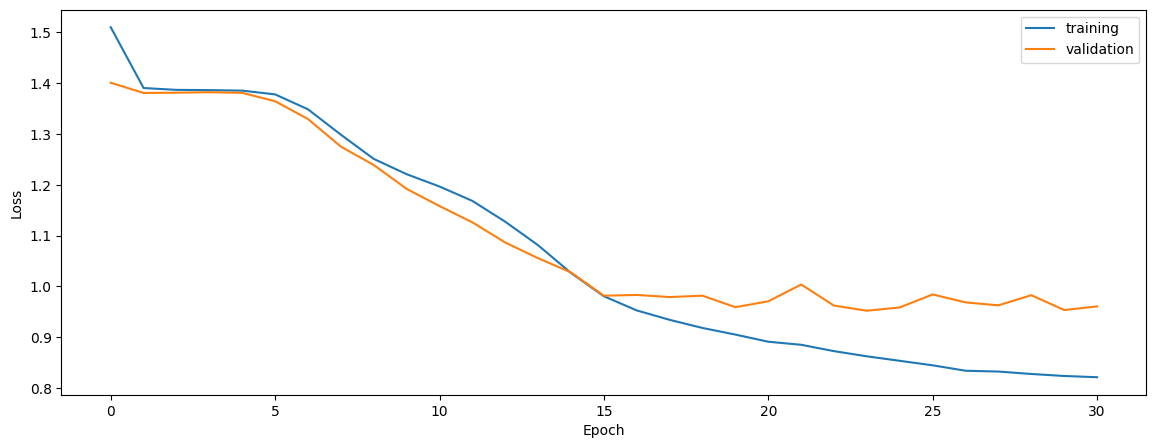

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.6575199475580682
0.6388557248870473
0.6626029654036244


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

native
0.6575199475580682
0.6388557248870473
0.6626029654036244


In [9]:
print('normalized')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6537568306010929
0.6323699421965318
0.6727344677483181


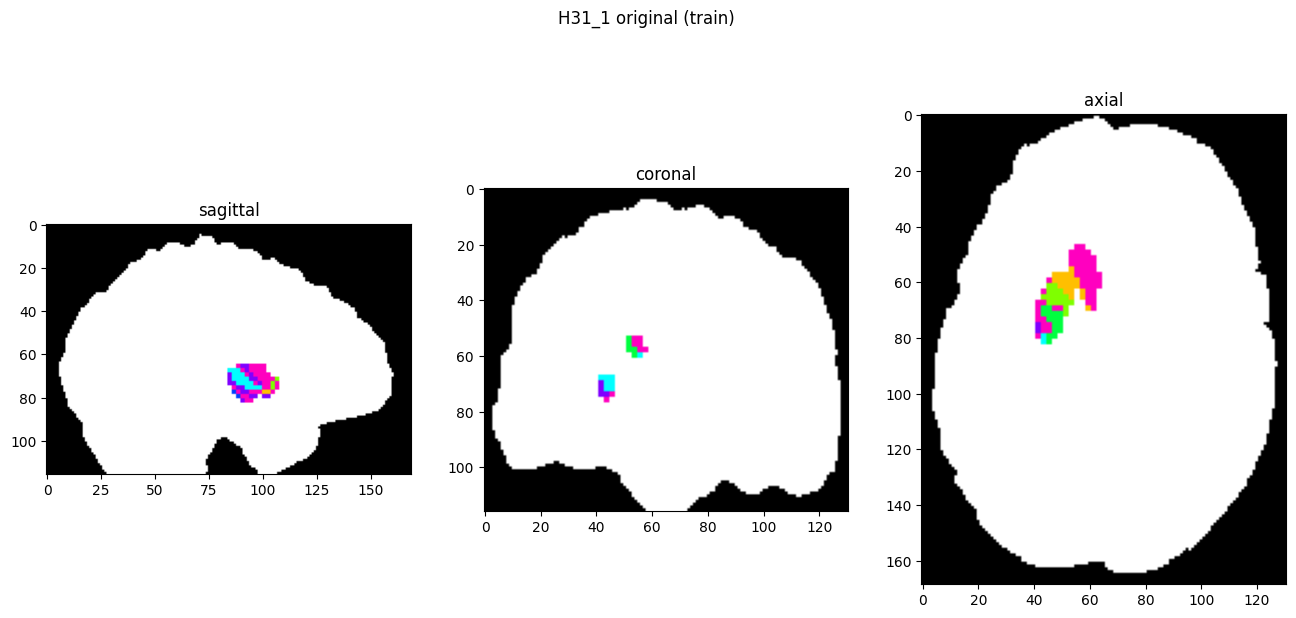

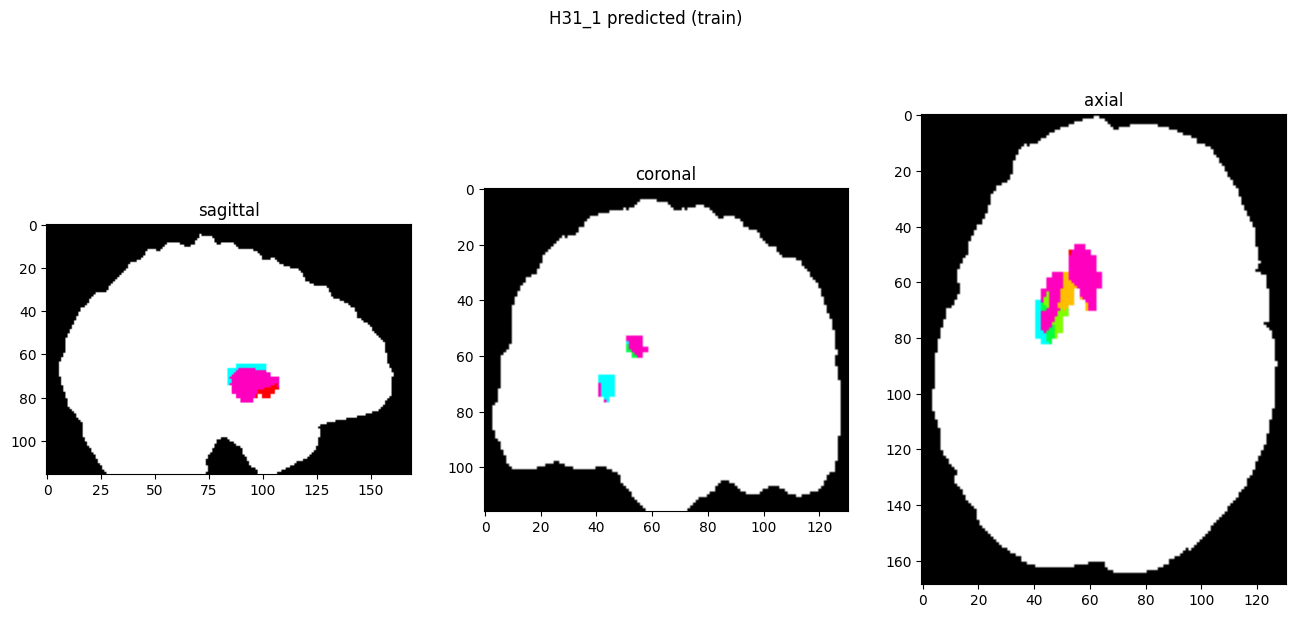

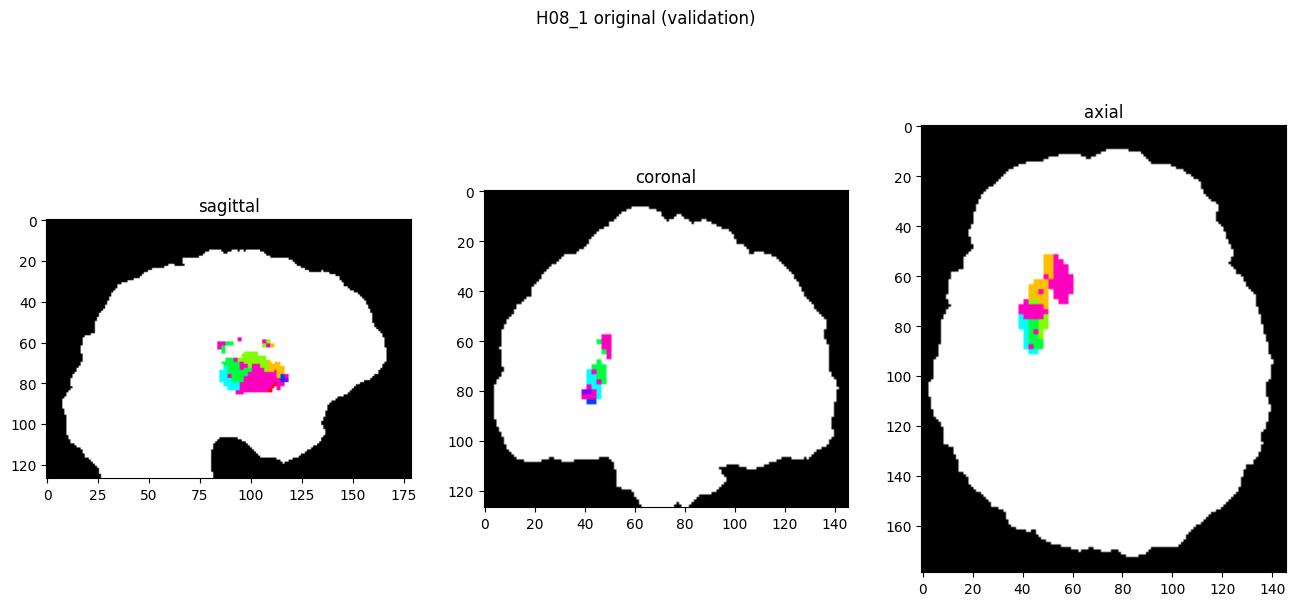

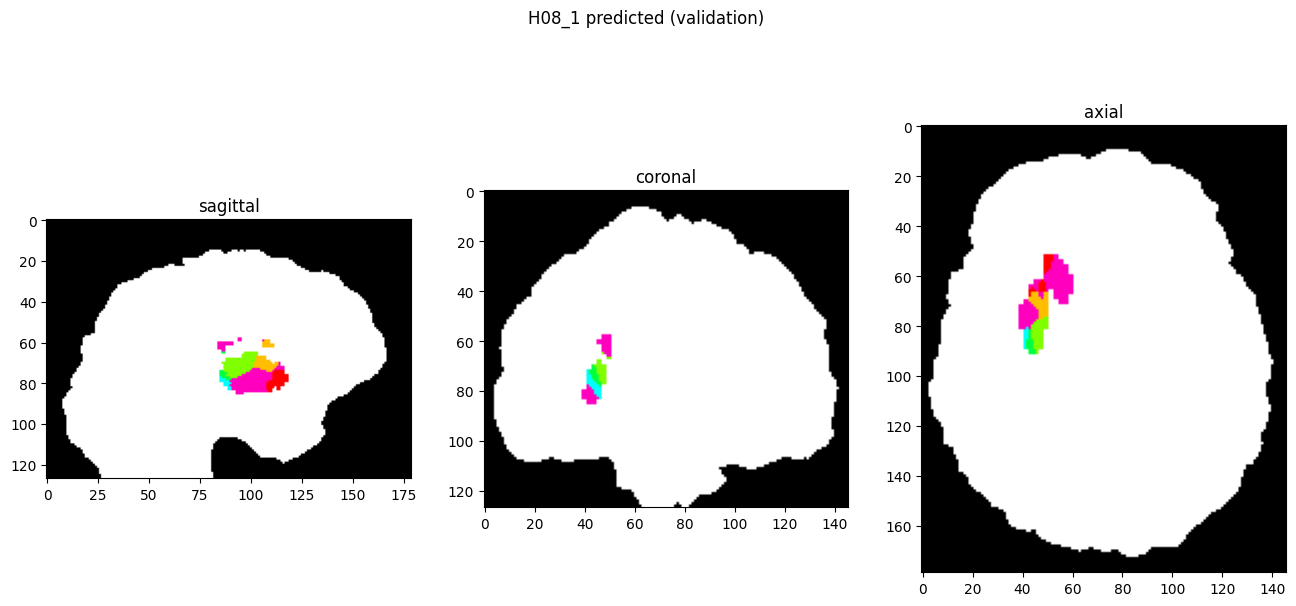

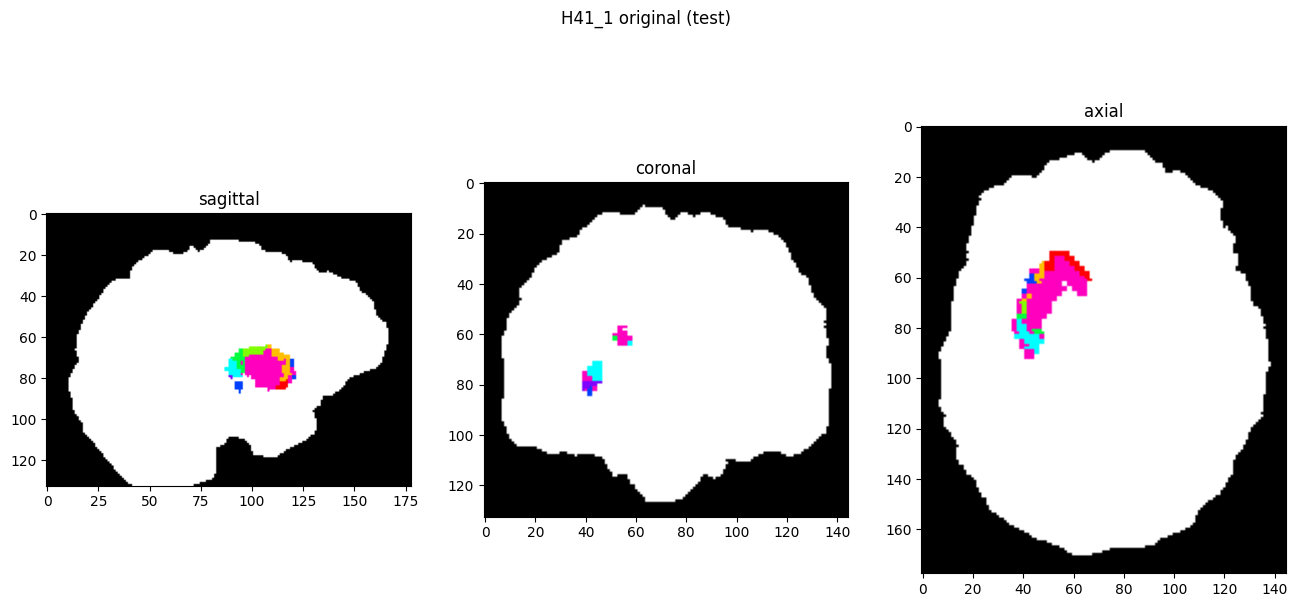

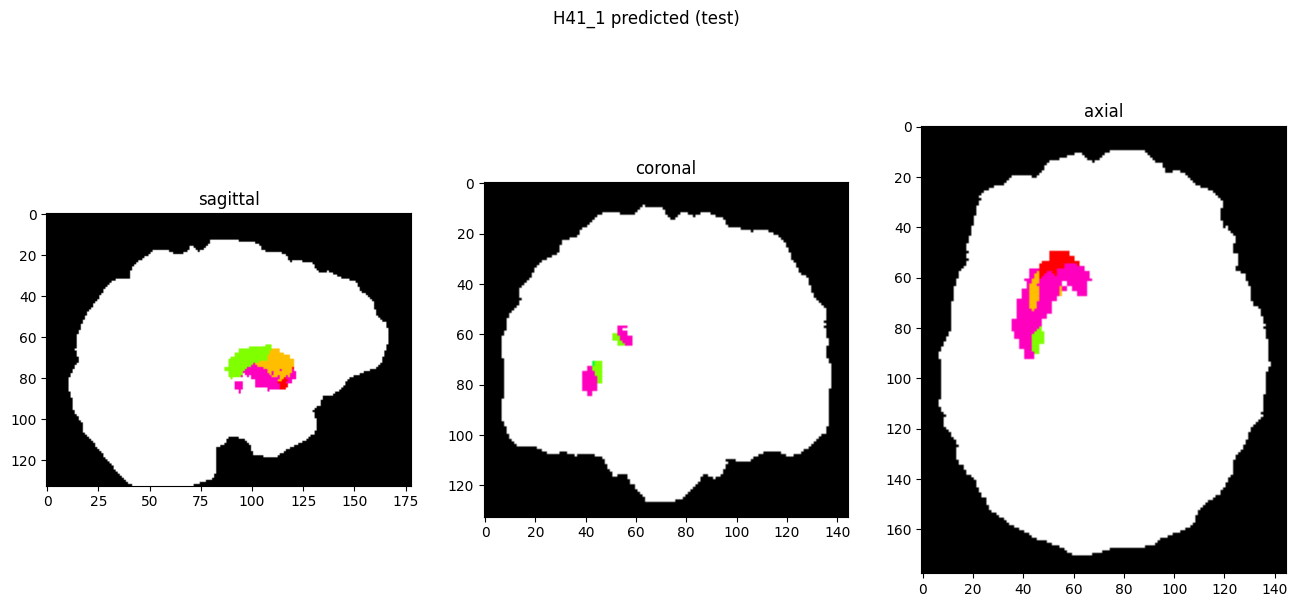

In [10]:
showResults(model, gen, threshold=0)